# Problem Statement

Houses have many variables that contribute to the final pricing of the sale. How big the house is for what the house contains can greatly affect the price. This project aims to predict house prices from the type of features that it has.

# Import libraries

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats 
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score,mean_squared_error


# Data cleaning

In [223]:
train_df = pd.read_csv('datasets/train.csv',keep_default_na=False, na_values=[''])
#The csv file has data that are listed as 'NA'. AS these are legitimate values according to the data dictionary, the above
#is added to prevent pandas from reading 'NA' as Nan
train_df = train_df[train_df['Gr Liv Area']<4000]
train_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,138500


the data dictionary recommends deleting rows where 'Gr living area' is >4000 so that is what I am doing here.

## data types in data set

|Type of Data(columns)|How it will be dealt with|
|---|---|
|Nominal (22)|groupby plot between categories and target variable. If the categories demonstrates an increasing relationship towards the target variable, it will be treated as ordinal data. Otherwise, it will be dealt with using 1 hot encoding|
|Ordinal (23)|Categories will be recoded as integers in ascending order, starting from 0 (e.g. 0,1,2,etc.)|
|Discrete (14)|unmodified|
|Continuous (20)|unmodified|

sale_condition not located in df. Originally 23 nominal variables is now 22

these are the data types in the dataset according to the data dictionary provided.

### rename columns

In [224]:
train_df.rename(columns=lambda x:x.lower().strip().replace(' ','_'),inplace=True)

strip, lowercase and change spacebars to underscores

### Exploring the dataset

In [225]:
train_df.iloc[:,:40].dtypes #1st 40 columns 

id                  int64
pid                 int64
ms_subclass         int64
ms_zoning          object
lot_frontage      float64
lot_area            int64
street             object
alley              object
lot_shape          object
land_contour       object
utilities          object
lot_config         object
land_slope         object
neighborhood       object
condition_1        object
condition_2        object
bldg_type          object
house_style        object
overall_qual        int64
overall_cond        int64
year_built          int64
year_remod/add      int64
roof_style         object
roof_matl          object
exterior_1st       object
exterior_2nd       object
mas_vnr_type       object
mas_vnr_area      float64
exter_qual         object
exter_cond         object
foundation         object
bsmt_qual          object
bsmt_cond          object
bsmt_exposure      object
bsmtfin_type_1     object
bsmtfin_sf_1      float64
bsmtfin_type_2     object
bsmtfin_sf_2      float64
bsmt_unf_sf 

In [226]:
train_df.iloc[:,41:].dtypes # remaining columns

heating_qc          object
central_air         object
electrical          object
1st_flr_sf           int64
2nd_flr_sf           int64
low_qual_fin_sf      int64
gr_liv_area          int64
bsmt_full_bath     float64
bsmt_half_bath     float64
full_bath            int64
half_bath            int64
bedroom_abvgr        int64
kitchen_abvgr        int64
kitchen_qual        object
totrms_abvgrd        int64
functional          object
fireplaces           int64
fireplace_qu        object
garage_type         object
garage_yr_blt      float64
garage_finish       object
garage_cars        float64
garage_area        float64
garage_qual         object
garage_cond         object
paved_drive         object
wood_deck_sf         int64
open_porch_sf        int64
enclosed_porch       int64
3ssn_porch           int64
screen_porch         int64
pool_area            int64
pool_qc             object
fence               object
misc_feature        object
misc_val             int64
mo_sold              int64
y

In [227]:
train_df.iloc[:,:40].describe().T

,count,mean,std,min,25%,50%,75%,max
id,2049.0,1.473676e+03,8.442481e+02,1.0,753.0,1481.0,2.199000e+03,2930.0
pid,2049.0,7.134001e+08,1.886859e+08,526301100.0,528458130.0,535453160.0,9.071760e+08,924152030.0
ms_subclass,2049.0,5.702538e+01,4.283727e+01,20.0,20.0,50.0,7.000000e+01,190.0
lot_frontage,1719.0,6.887900e+01,2.247211e+01,21.0,58.0,68.0,8.000000e+01,313.0
lot_area,2049.0,1.002468e+04,6.608512e+03,1300.0,7500.0,9405.0,1.150000e+04,159000.0
overall_qual,2049.0,6.108346e+00,1.421780e+00,1.0,5.0,6.0,7.000000e+00,10.0
overall_cond,2049.0,5.562714e+00,1.104897e+00,1.0,5.0,5.0,6.000000e+00,9.0
year_built,2049.0,1.971673e+03,3.017129e+01,1872.0,1953.0,1974.0,2.001000e+03,2010.0
year_remod/add,2049.0,1.984166e+03,2.103279e+01,1950.0,1964.0,1993.0,2.004000e+03,2010.0
mas_vnr_area,2027.0,9.879773e+01,1.725638e+02,0.0,0.0,0.0,1.600000e+02,1600.0


In [228]:
train_df.iloc[:,41:].describe().T

,count,mean,std,min,25%,50%,75%,max
1st_flr_sf,2049.0,1160.848219,379.066122,334.0,879.0,1092.0,1404.0,3820.0
2nd_flr_sf,2049.0,329.186920,425.595710,0.0,0.0,0.0,691.0,1862.0
low_qual_fin_sf,2049.0,5.518302,51.093509,0.0,0.0,0.0,0.0,1064.0
gr_liv_area,2049.0,1495.553441,485.783577,334.0,1128.0,1444.0,1728.0,3820.0
bsmt_full_bath,2047.0,0.426478,0.521617,0.0,0.0,0.0,1.0,3.0
bsmt_half_bath,2047.0,0.063019,0.250971,0.0,0.0,0.0,0.0,2.0
full_bath,2049.0,1.576867,0.549389,0.0,1.0,2.0,2.0,4.0
half_bath,2049.0,0.370425,0.500901,0.0,0.0,0.0,1.0,2.0
bedroom_abvgr,2049.0,2.843826,0.826804,0.0,2.0,3.0,3.0,8.0
kitchen_abvgr,2049.0,1.042948,0.209888,0.0,1.0,1.0,1.0,3.0


the max value for the variable garage_yr_built is 2207. This is likely a mistake and will be changed to 2007

In [229]:
train_df.loc[train_df['garage_yr_blt']==2207,'garage_yr_blt':]

,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1699,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,...,0,0,NA,NA,NA,0,9,2007,New,267300


In [230]:
train_df.loc[train_df['garage_yr_blt']==2207,'garage_yr_blt'] = 2007

### how many Nan values within each columns

In [231]:
train_df.loc[:, train_df.isna().any()].isna().sum() #show only columns with more than 1 Nan value

lot_frontage      330
mas_vnr_type       22
mas_vnr_area       22
bsmt_qual           1
bsmt_cond           1
bsmt_exposure       4
bsmtfin_type_1      1
bsmtfin_sf_1        1
bsmtfin_type_2      2
bsmtfin_sf_2        1
bsmt_unf_sf         1
total_bsmt_sf       1
bsmt_full_bath      2
bsmt_half_bath      2
garage_yr_blt     114
garage_finish       1
garage_cars         1
garage_area         1
garage_qual         1
garage_cond         1
dtype: int64

### Delete Rows

There seems to be one missing value in each of the bsmt variables.

In [211]:
train_df.loc[train_df['bsmt_cond'].isna(),'bsmt_cond':]

,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,...,0,0,NA,MnPrv,NA,0,4,2008,ConLD,79000


Since the missing values for bsmt variables come from this row, it will be dropped 

In [238]:
train_df.drop(index=1327,inplace=True)

The same thing has been observed in the garage variables

In [233]:
train_df.loc[train_df['garage_finish'].isna(),'garage_finish':]

,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1712,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NA,MnPrv,NA,0,3,2007,WD,150909


This row will be dropped as well

In [234]:
train_df.drop(index=1712,inplace=True)

### Remaining columns with Nan values

In [239]:
train_df.loc[:, train_df.isna().any()].isna().sum() 

lot_frontage      330
mas_vnr_type       22
mas_vnr_area       22
bsmt_exposure       3
bsmtfin_type_2      1
bsmt_full_bath      1
bsmt_half_bath      1
garage_yr_blt     113
dtype: int64

|column name|missing values|how to deal with missing|
|---|---|---|
|lot_frontage    |   330| replace with median of neighborhood |
|mas_vnr_type      |  22| None, replace with 'None' |
|mas_vnr_area       | 22| None, replace with 0 |
|bsmt_exposure    |   3  |No basement, replace with 'NA'|
|bsmtfin_type_2    |  1 | No basement, replace with 'NA'|
|bsmt_full_bath    |  1 | No basement, replace with 0|
|bsmt_half_bath    |   1  | No basement, replace with 0|
|garage_yr_blt    |  113  |No garage, replace with 0|

## Dealing with missing variables

### Dtypes for columns with missing variables

In [271]:
train_df.loc[:, train_df.isna().any()].dtypes

lot_frontage      float64
mas_vnr_type       object
mas_vnr_area      float64
bsmt_exposure      object
bsmtfin_type_2     object
bsmt_full_bath    float64
bsmt_half_bath    float64
garage_yr_blt     float64
dtype: object

### Fill nan values of lot_frontage with median values of each neighborhood

In [288]:
train_df['lot_frontage'].fillna(train_df['lot_frontage'].median(),inplace=True)

### Fill nan values of mas_vnr_type with 'none'

In [289]:
train_df['mas_vnr_type'].fillna('None',inplace=True)

most variables in the data column are listed as 0 or 'NA' if the column does not apply to them. This column is an exception as such values are listed as 'None'

### Fill all remaining empty numeric columns with 0 and all empty object columns with 'NA'

In [290]:
train_df=train_df.apply(lambda x: x.fillna('NA') if x.dtypes == 'O' else x.fillna(0))
train_df.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,68.0,13517,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,138500


### Check if there are any missing values remaining

In [291]:
train_df.loc[:, train_df.isna().any()].isna().sum() 

Series([], dtype: float64)

## Filter for categorical data

According to the data dictionary from kaggle, the dataset has 22 ordinal variables and 23 nominal variables. The following blocks of code identifies those variables from the dataset

In [292]:
# this function excludes all numeric dtypes. contain ordinal and nominal data
train_df_cat = train_df.select_dtypes(exclude=[np.number]) 

# These columns are numeric dtypes but are actually categorical according to the data dictionary
num_cat = train_df[['ms_subclass','overall_qual', 'overall_cond']]

# Combines both columns into one df containing all categorical variables
train_df_cat = pd.concat([train_df_cat,num_cat], axis='columns')

train_df_cat.head()

,ms_zoning,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,...,garage_qual,garage_cond,paved_drive,pool_qc,fence,misc_feature,sale_type,ms_subclass,overall_qual,overall_cond
0,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,...,TA,TA,Y,NA,NA,NA,WD,60,6,8
1,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,...,TA,TA,Y,NA,NA,NA,WD,60,7,5
2,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,TA,TA,Y,NA,NA,NA,WD,20,5,7
3,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,...,TA,TA,Y,NA,NA,NA,WD,60,5,5
4,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,...,TA,TA,N,NA,NA,NA,WD,50,6,8


### Split categorical data in Nominal and Ordinal

In [293]:
# list of nominal features as mentioned in the kaggle data dictionary
nominal_filter = ['ms_subclass', 'ms_zoning', 'street', 'alley', 'land_contour', 'lot_config', 
                 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 
                 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 
                  'foundation', 'heating', 'central_air', 'garage_type', 'misc_feature', 'sale_type']

# subset of train_df containing only nominal values
train_df_nom = train_df_cat[nominal_filter] 

# nominal values + price
train_df_nom_price = pd.concat([train_df_nom,train_df['saleprice']],axis=1) 

# subset of train_df containing only ordinal values
train_df_ord = train_df_cat.drop(columns=nominal_filter)

# ordinal values + saleprice
train_df_ord_price = pd.concat([train_df_ord,train_df['saleprice']],axis=1)


# EDA

### groupby plots for categorical data against price

#### Create a function that plots the mean values for categorical values against saleprice

In [606]:
def groupbyplots(df,target,cols=3,figsize=(20,40)):
    # set number of axis rows. "df.columns[:-1]" is to ensure that saleprice is not accounted for when making rows
    rows = int(np.ceil(len(df.columns[:-1])/cols))
    
    fig, ax = plt.subplots(nrows = rows,ncols= cols ,figsize=figsize,constrained_layout=True )
    ax = ax.ravel()

    for i, col in enumerate(df.columns[:-1]): # dont include saleprice vs saleprice
        df.groupby(col)[target].mean().sort_values().plot(kind='bar',ax=ax[i])
        ax[i].set_xlabel(col,fontsize=20)
        ax[i].set_ylabel('sale_price', fontsize=20)
        ax[i].xaxis.set_tick_params(labelsize=15)
        ax[i].yaxis.set_tick_params(labelsize=15)

    


    

#### Plot for Ordinal variables 

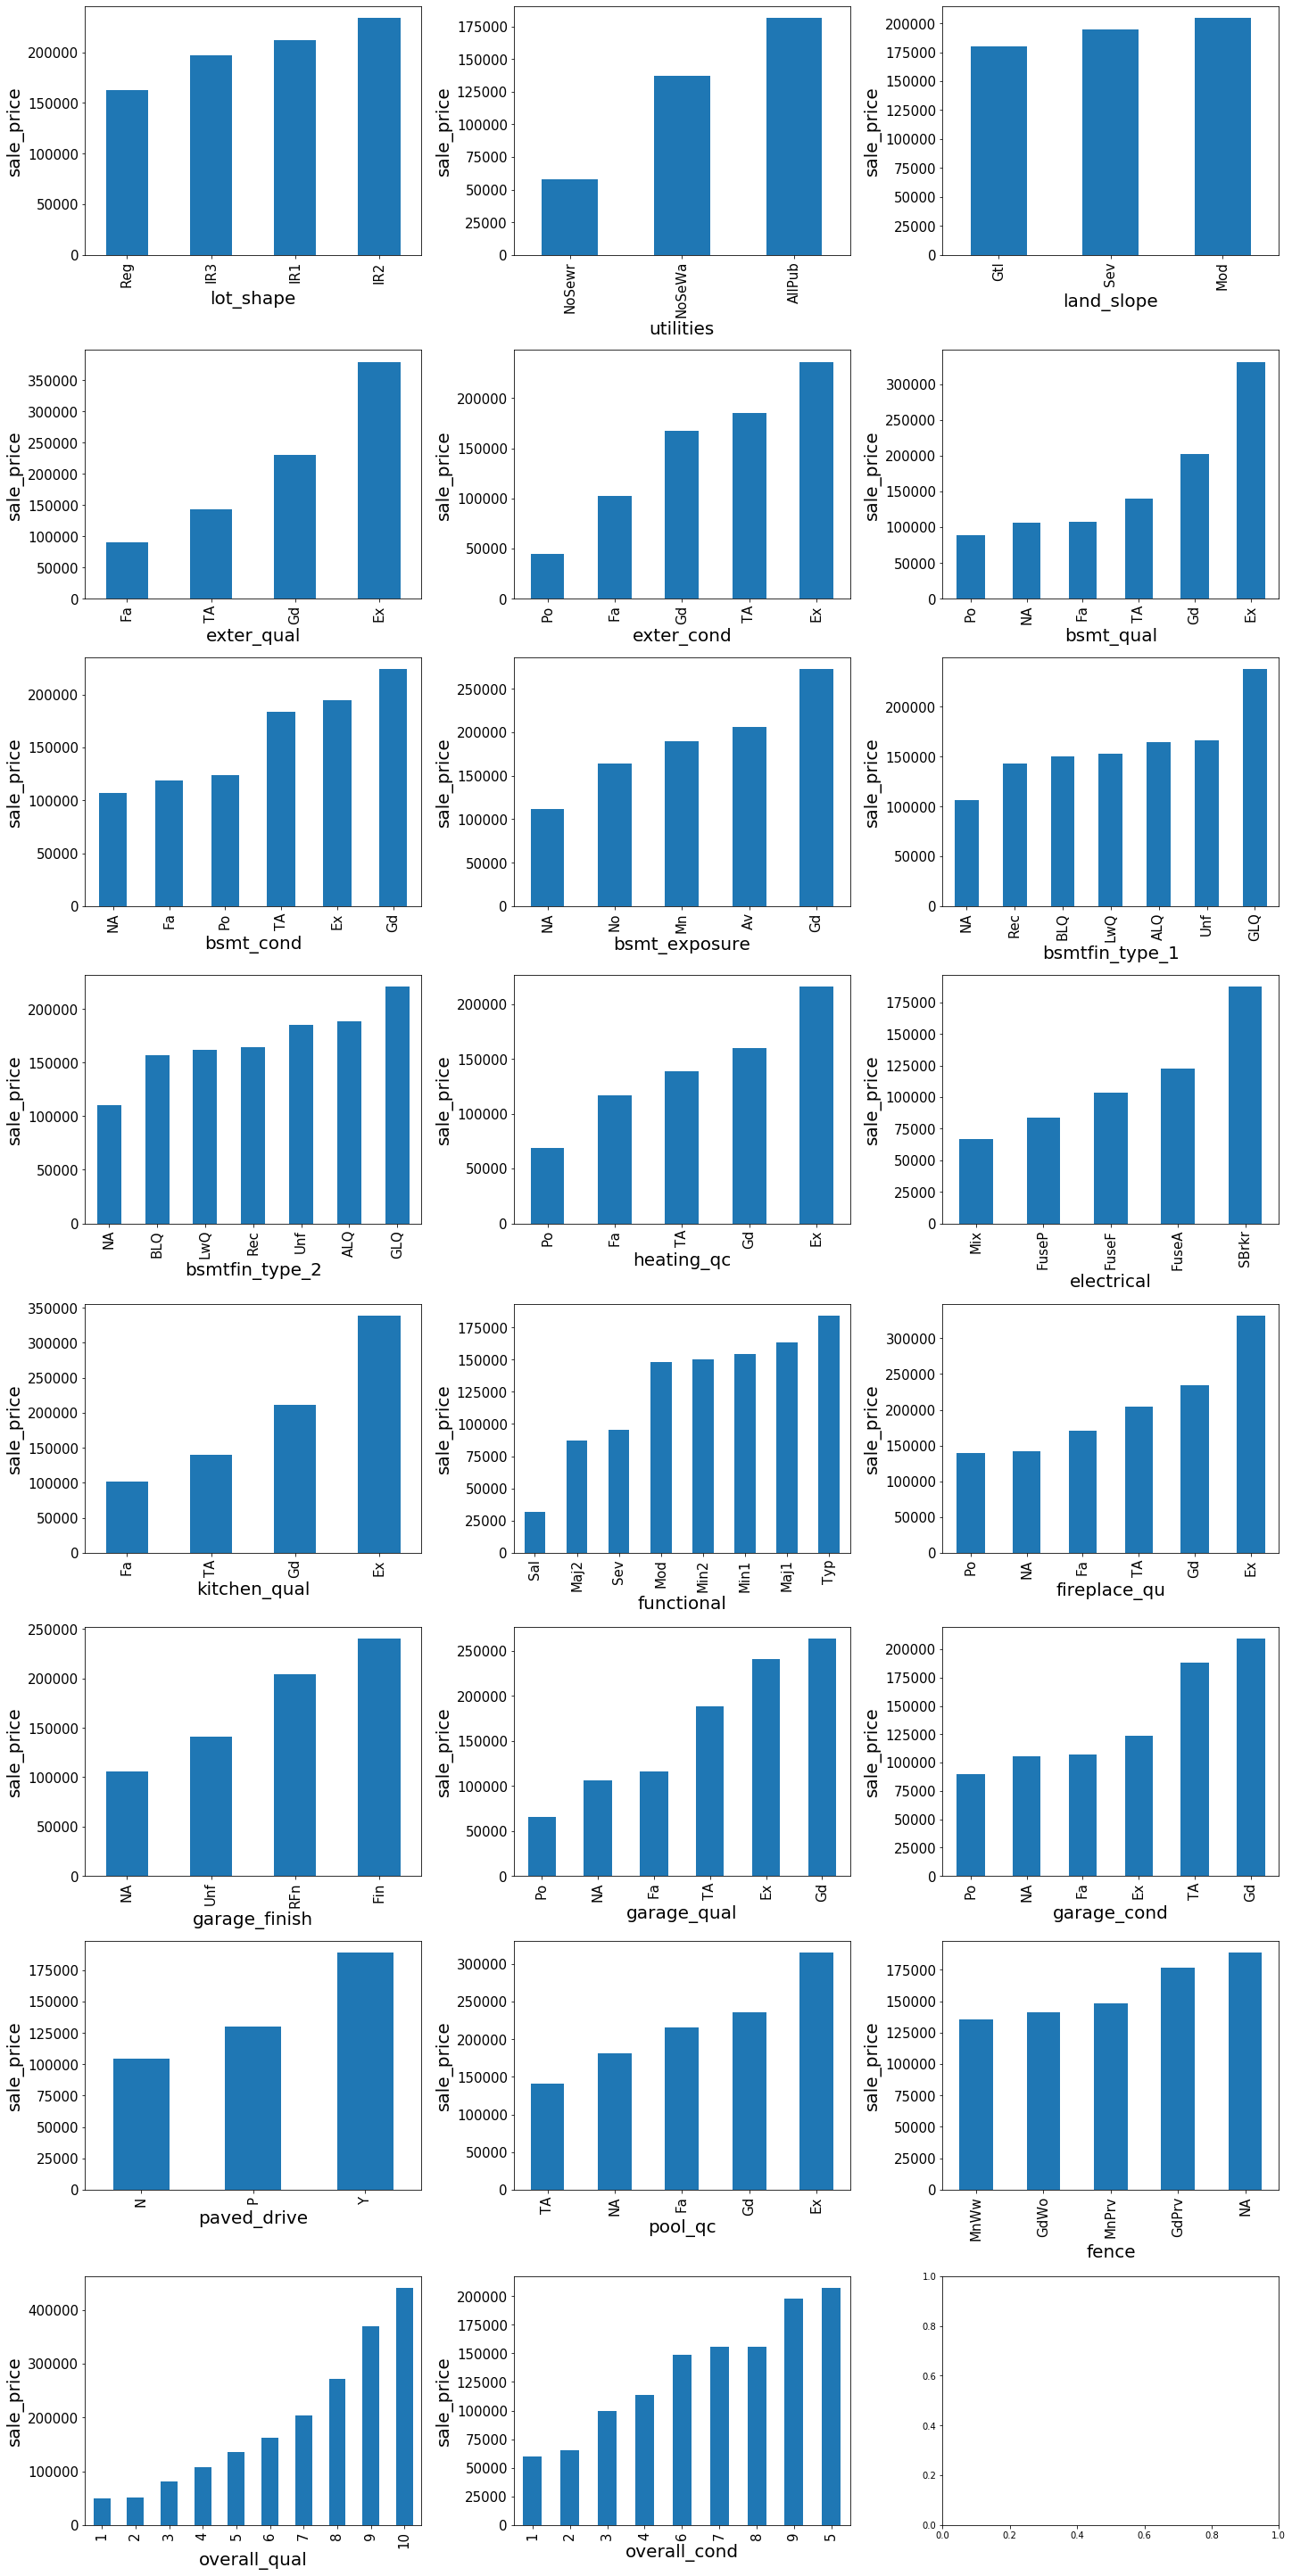

In [515]:
groupbyplots(train_df_ord_price,'saleprice')

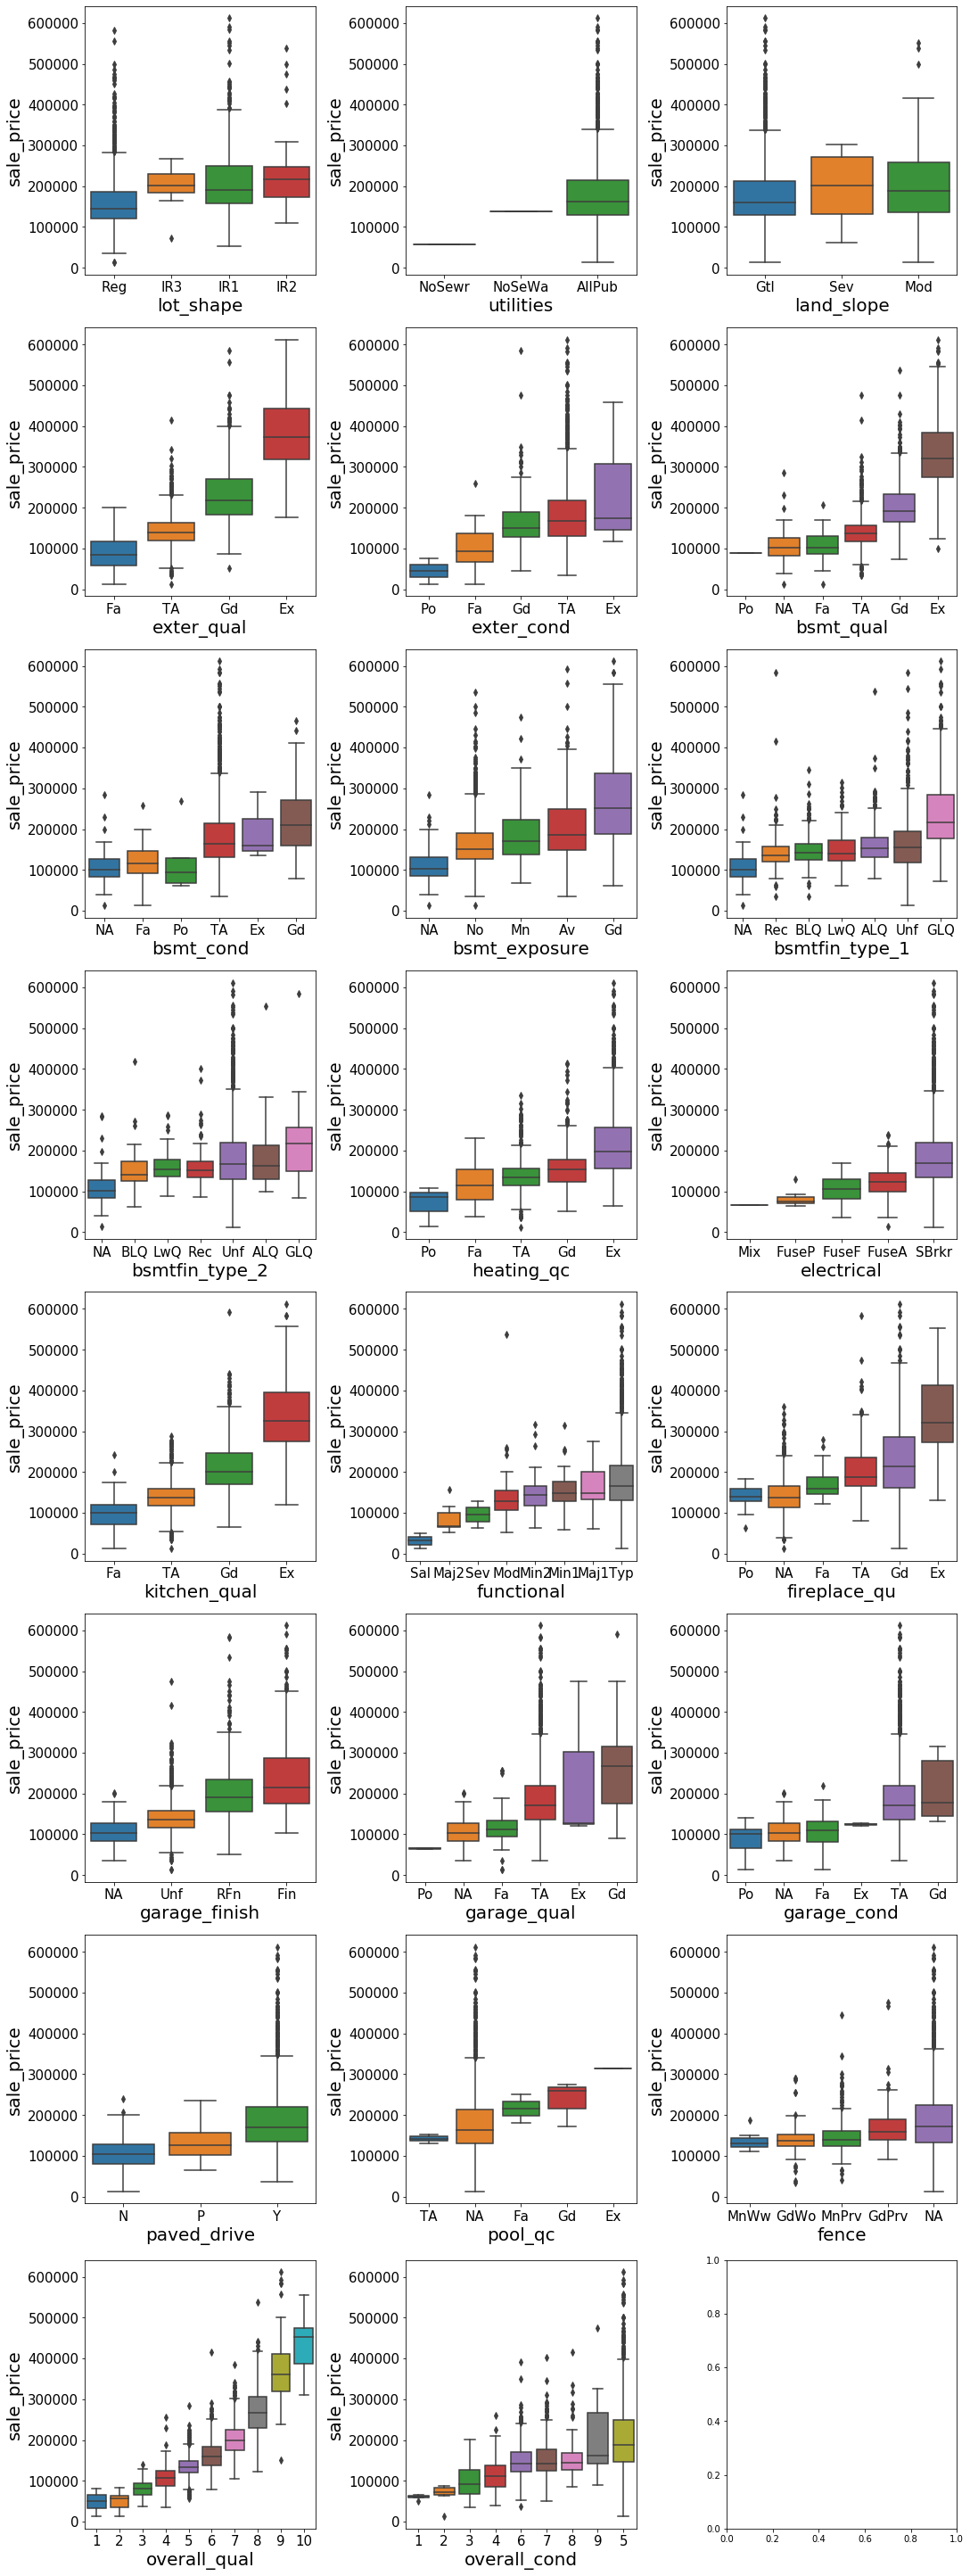

In [617]:
ordinal_columns = train_df_ord_price.columns
cols = 3
rows = int(np.ceil(len(ordinal_columns[:-1])/cols))
fig, ax = plt.subplots(nrows = rows,ncols= cols ,figsize=(15,40),constrained_layout=True )
ax = ax.ravel()

for i, col in enumerate(ordinal_columns[:-1]):
    sorted_order= train_df_ord_price.groupby(col)['saleprice'].mean().sort_values().index
    sns.boxplot(x=train_df_ord_price[col],y= train_df_ord_price['saleprice'],ax=ax[i],order = sorted_order)
    ax[i].set_xlabel(col,fontsize=20)
    ax[i].set_ylabel('sale_price',fontsize=20)
    ax[i].xaxis.set_tick_params(labelsize=15)
    ax[i].yaxis.set_tick_params(labelsize=15)
    
    


From the graphs above, we can see that there is a relationship between the groups and saleprice for each variable. However, this relationship seems to be stronger in certain variables than others. It is most noticeable in overall_qual.

#### Plot for Nominal variables 

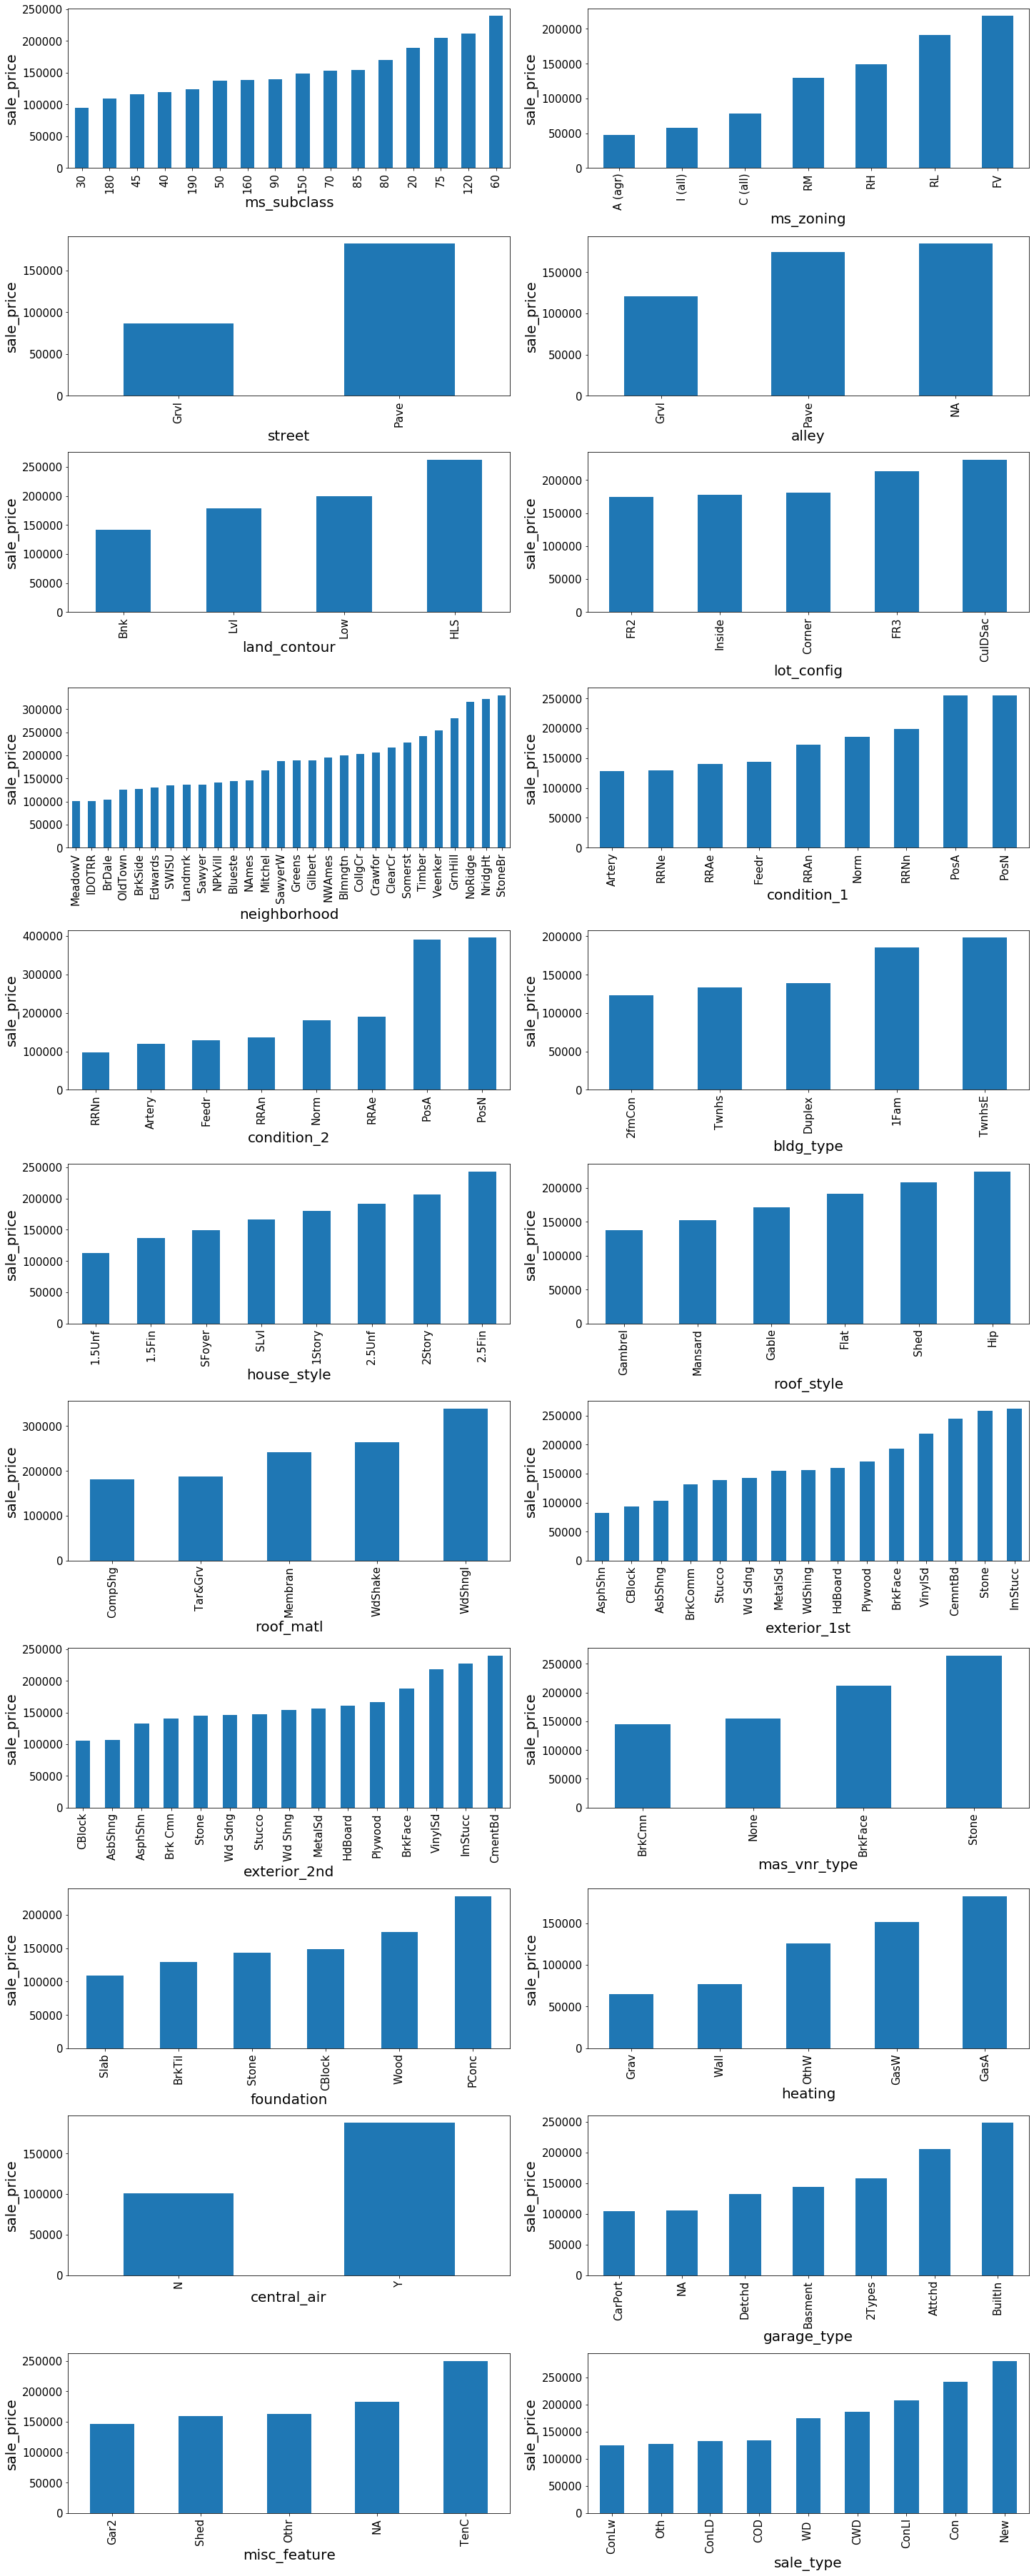

In [518]:
groupbyplots(train_df_nom_price,'saleprice',2,(20,50))

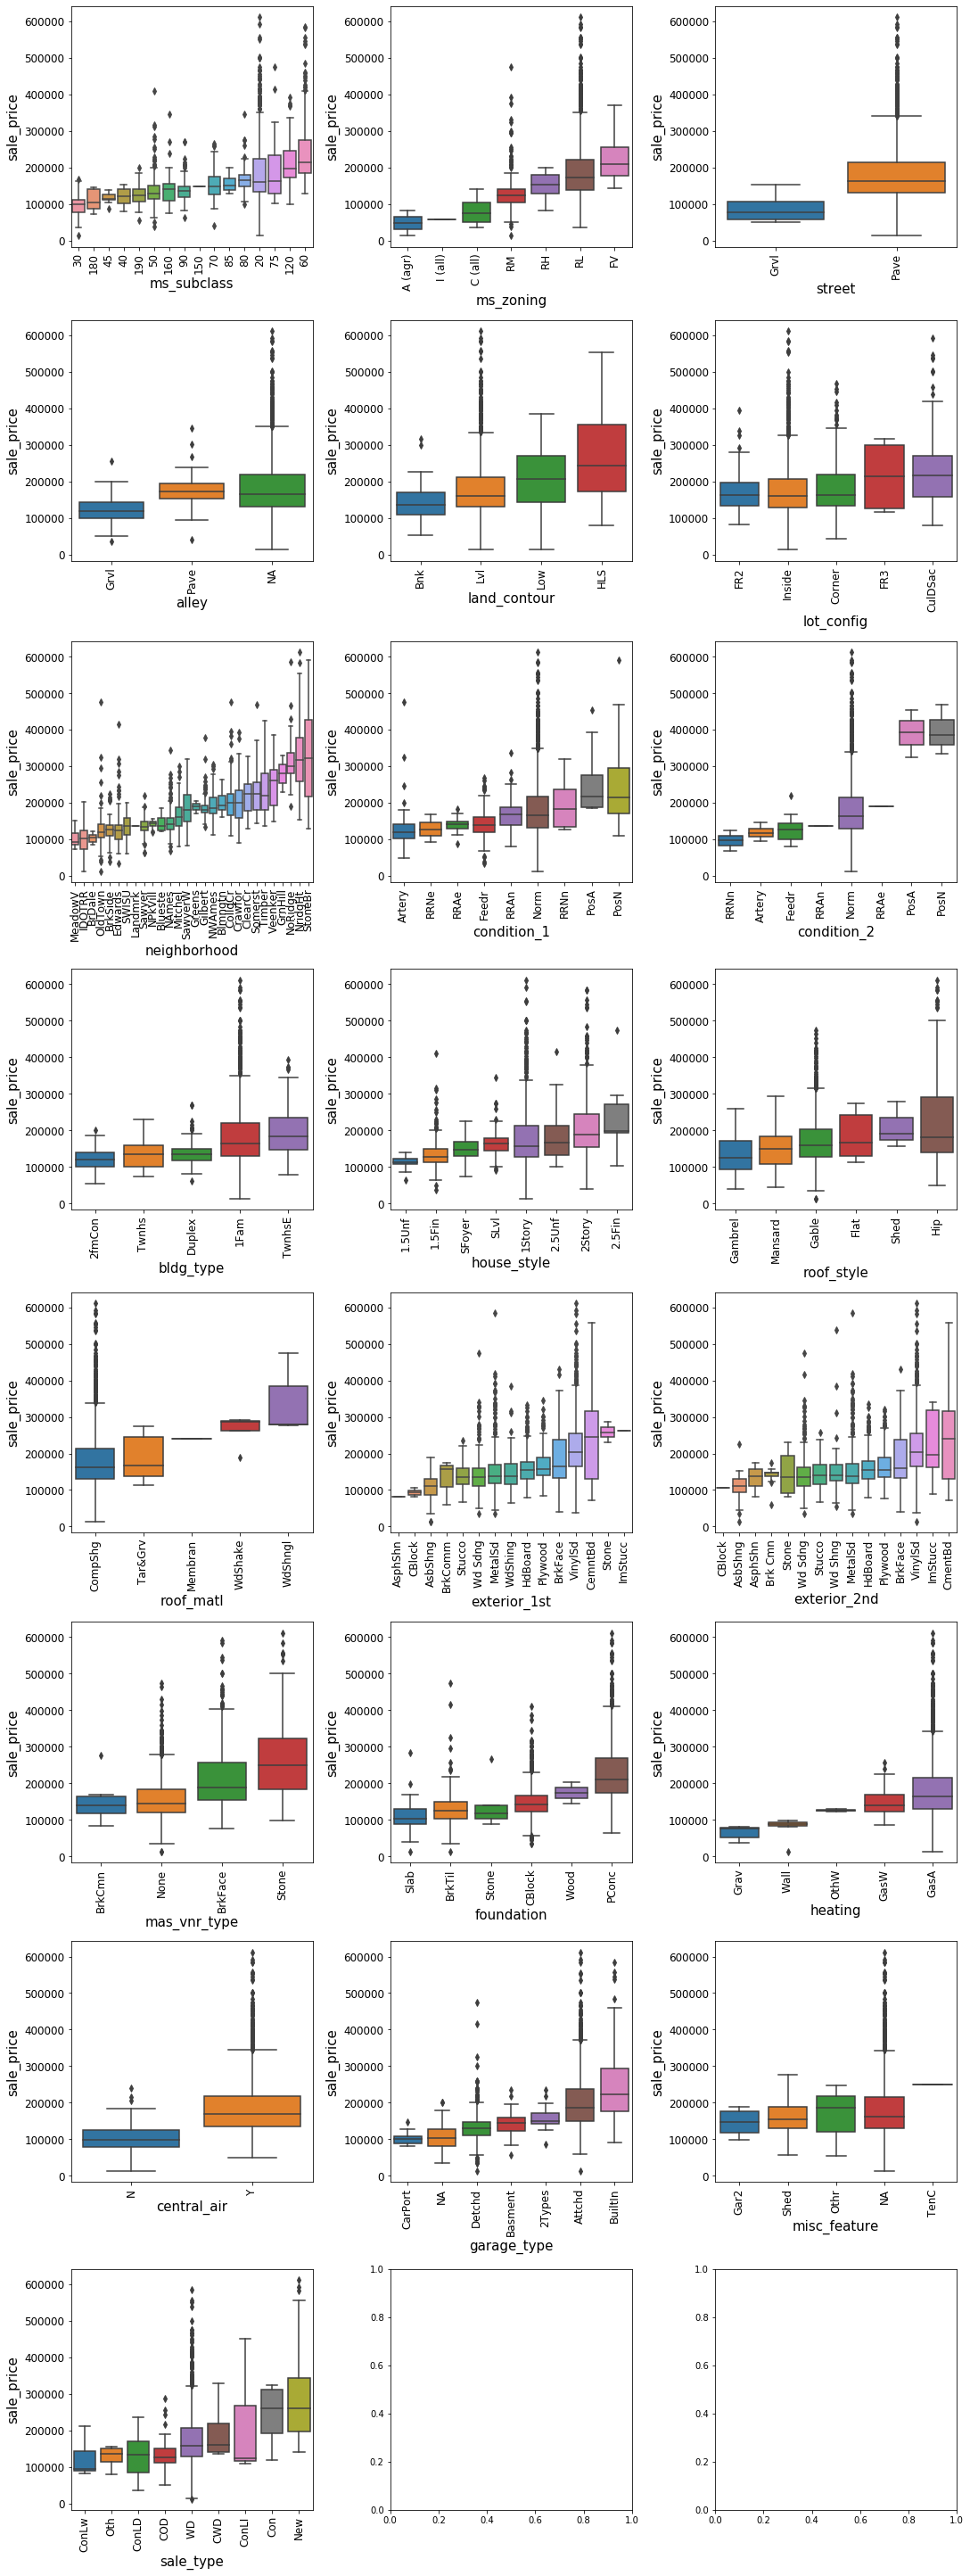

In [623]:
nominal_columns = train_df_nom_price.columns
cols = 3
rows = int(np.ceil(len(nominal_columns[:-1])/cols))
fig, ax = plt.subplots(nrows = rows,ncols= cols ,figsize=(15,40),constrained_layout=True )
ax = ax.ravel()

for i, col in enumerate(nominal_columns[:-1]):
    sorted_order= train_df_nom_price.groupby(col)['saleprice'].mean().sort_values().index
    sns.boxplot(x=train_df_nom_price[col],y= train_df_nom_price['saleprice'],ax=ax[i],order = sorted_order)
    ax[i].set_xlabel(col,fontsize=15)
    ax[i].set_ylabel('sale_price',fontsize=15)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation='vertical')
    ax[i].xaxis.set_tick_params(labelsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)



The plots show that there are noticeable differences in saleprice between at least 2 categories within each plot.

## Plots for non categorical data (numeric)

### Create numeric only dataframe

In [624]:
train_df_num = train_df._get_numeric_data()
train_df_num_incl_price = train_df_num.iloc[:,2:].drop(columns= ['ms_subclass','overall_qual', 'overall_cond'])


#### Create heatmap for numeric data

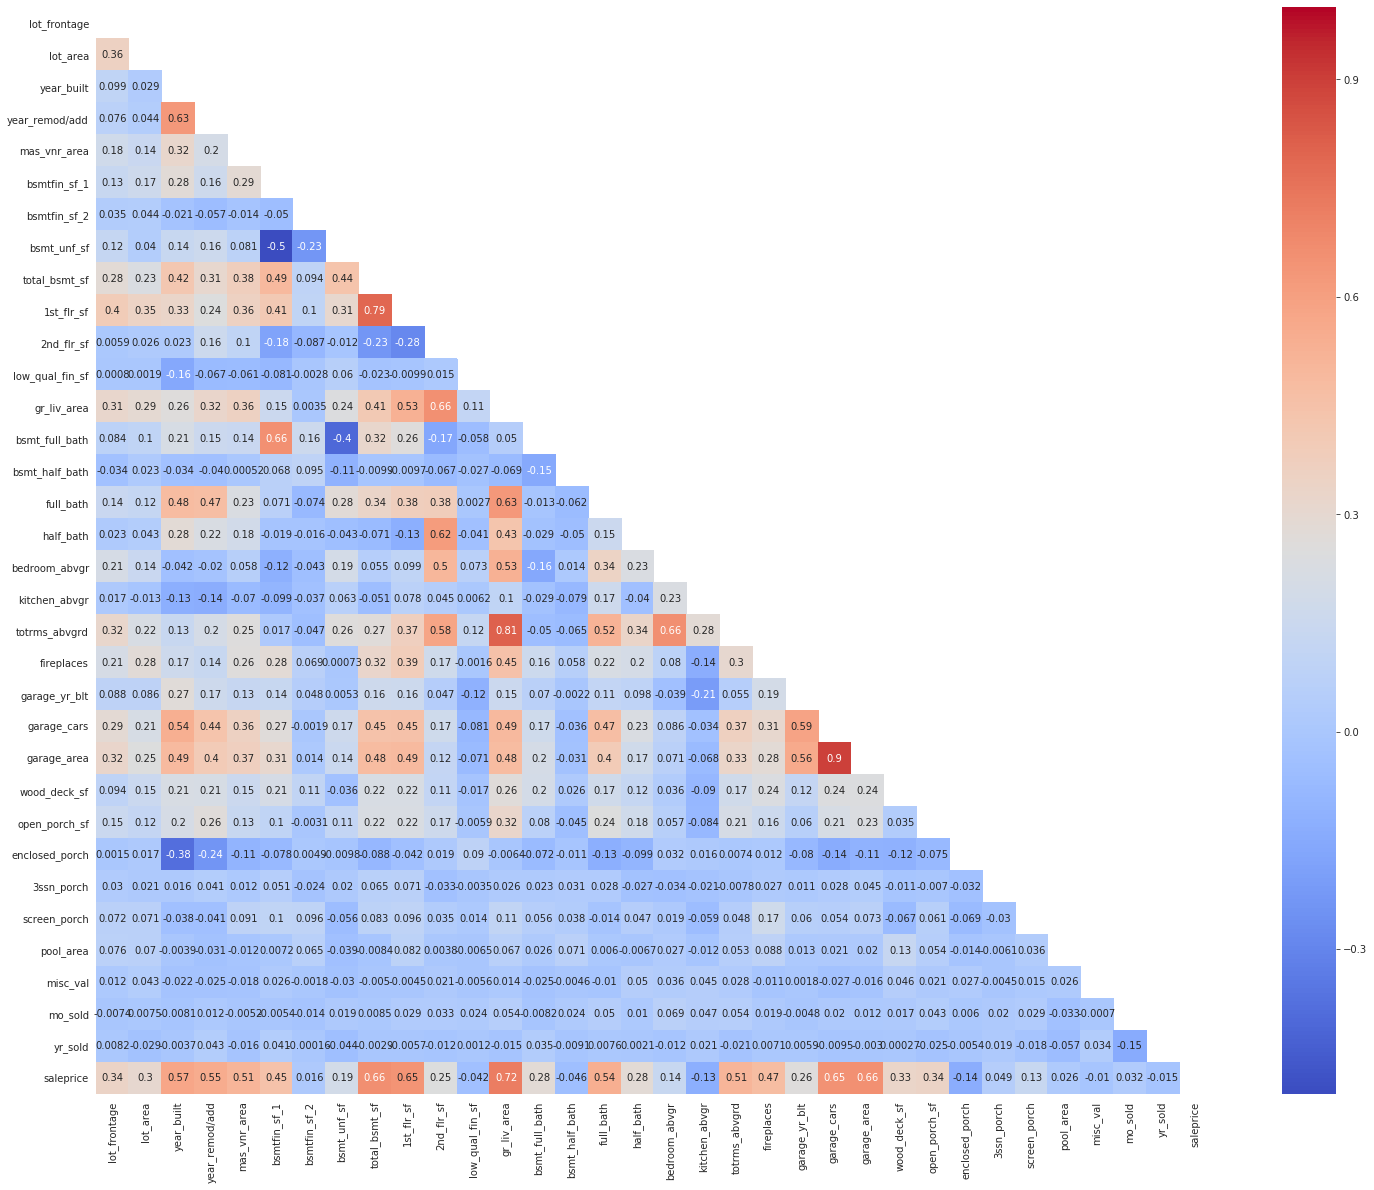

In [642]:
plt.figure(figsize=(25,20))


mask = np.zeros_like(train_df_num_incl_price.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    sns.heatmap(train_df_num_incl_price.corr(), mask=mask, cmap='coolwarm',annot=True)

The heatmap above show that some features are highly correlated with each other

#### Show numeric features that are most highly correlated to saleprice

In [630]:
# instead of returning the entire correlation matrix, locate only saleprice
price_vs_num_features_only= train_df_num_incl_price.corr().loc[:,['saleprice',]] 

price_vs_num_features_only.sort_values('saleprice',ascending=False).style.background_gradient() #style dataframe

,saleprice
saleprice,1
gr_liv_area,0.719483
total_bsmt_sf,0.66479
garage_area,0.655312
garage_cars,0.648454
1st_flr_sf,0.64812
year_built,0.572283
year_remod/add,0.550645
full_bath,0.538169
mas_vnr_area,0.511115


#### Plot numeric features against saleprice

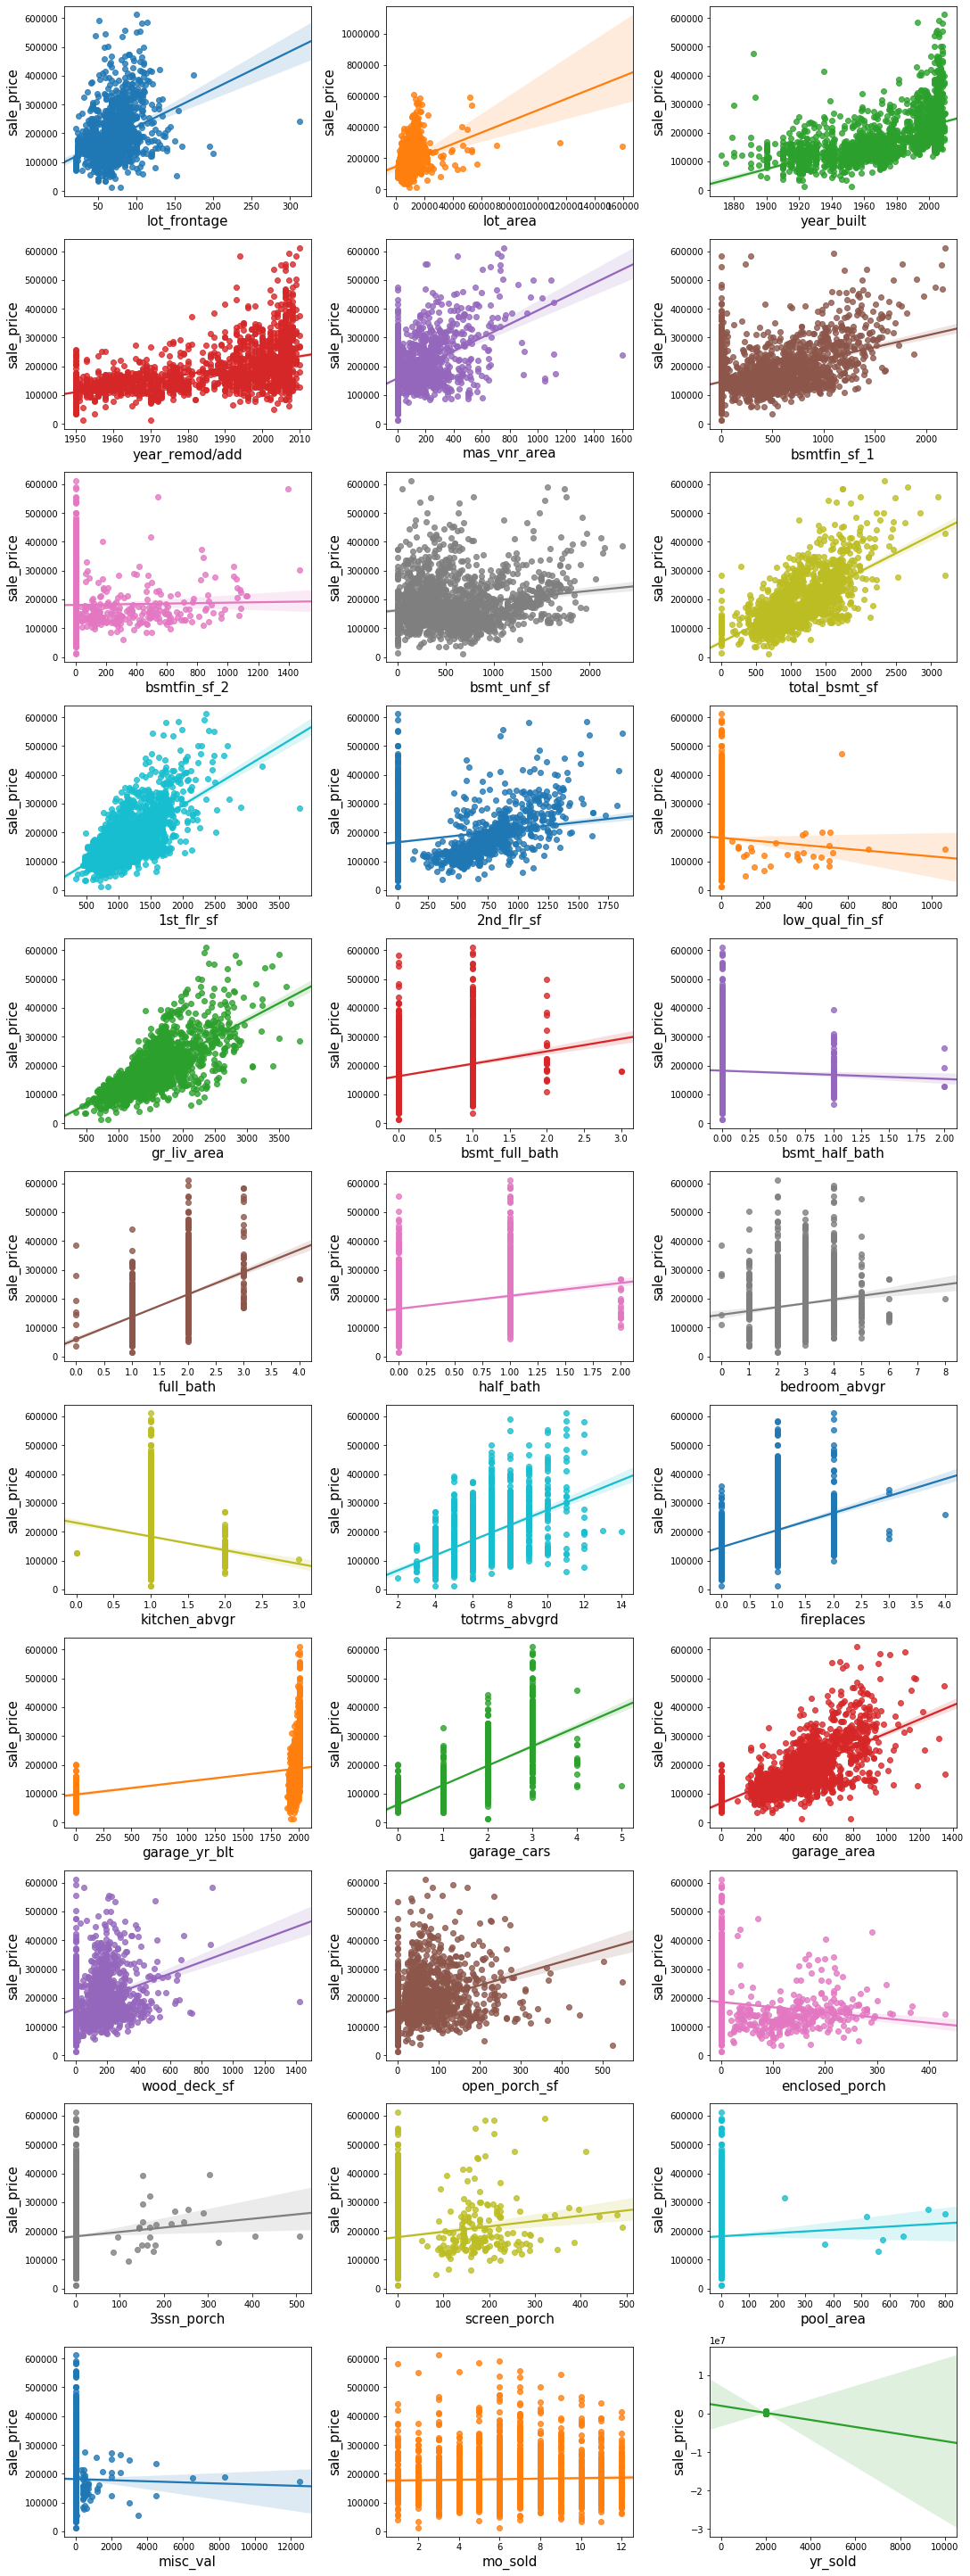

In [644]:
numeric_columns = train_df_num_incl_price.columns
cols = 3
rows = int(np.ceil(len(numeric_columns[:-1])/cols))
fig, ax = plt.subplots(nrows = rows,ncols= cols ,figsize=(15,40),constrained_layout=True )
ax = ax.ravel()

for i, col in enumerate(numeric_columns[:-1]):
    sns.regplot(train_df_num_incl_price[col],train_df_num_incl_price['saleprice'],ax=ax[i])
    ax[i].set_xlabel(col,fontsize=15)
    ax[i].set_ylabel('sale_price',fontsize=15)
    ax[i].xaxis.set_tick_params(labelsize=10)
    ax[i].yaxis.set_tick_params(labelsize=10)

The graphs above show the strength relationship of the features against saleprice. In some graphs, there are outliers that significantly affect the best fit line. This is obvious in 'lot_area'. Hence these outliers will be removed.

#### Plot histograms for numeric features

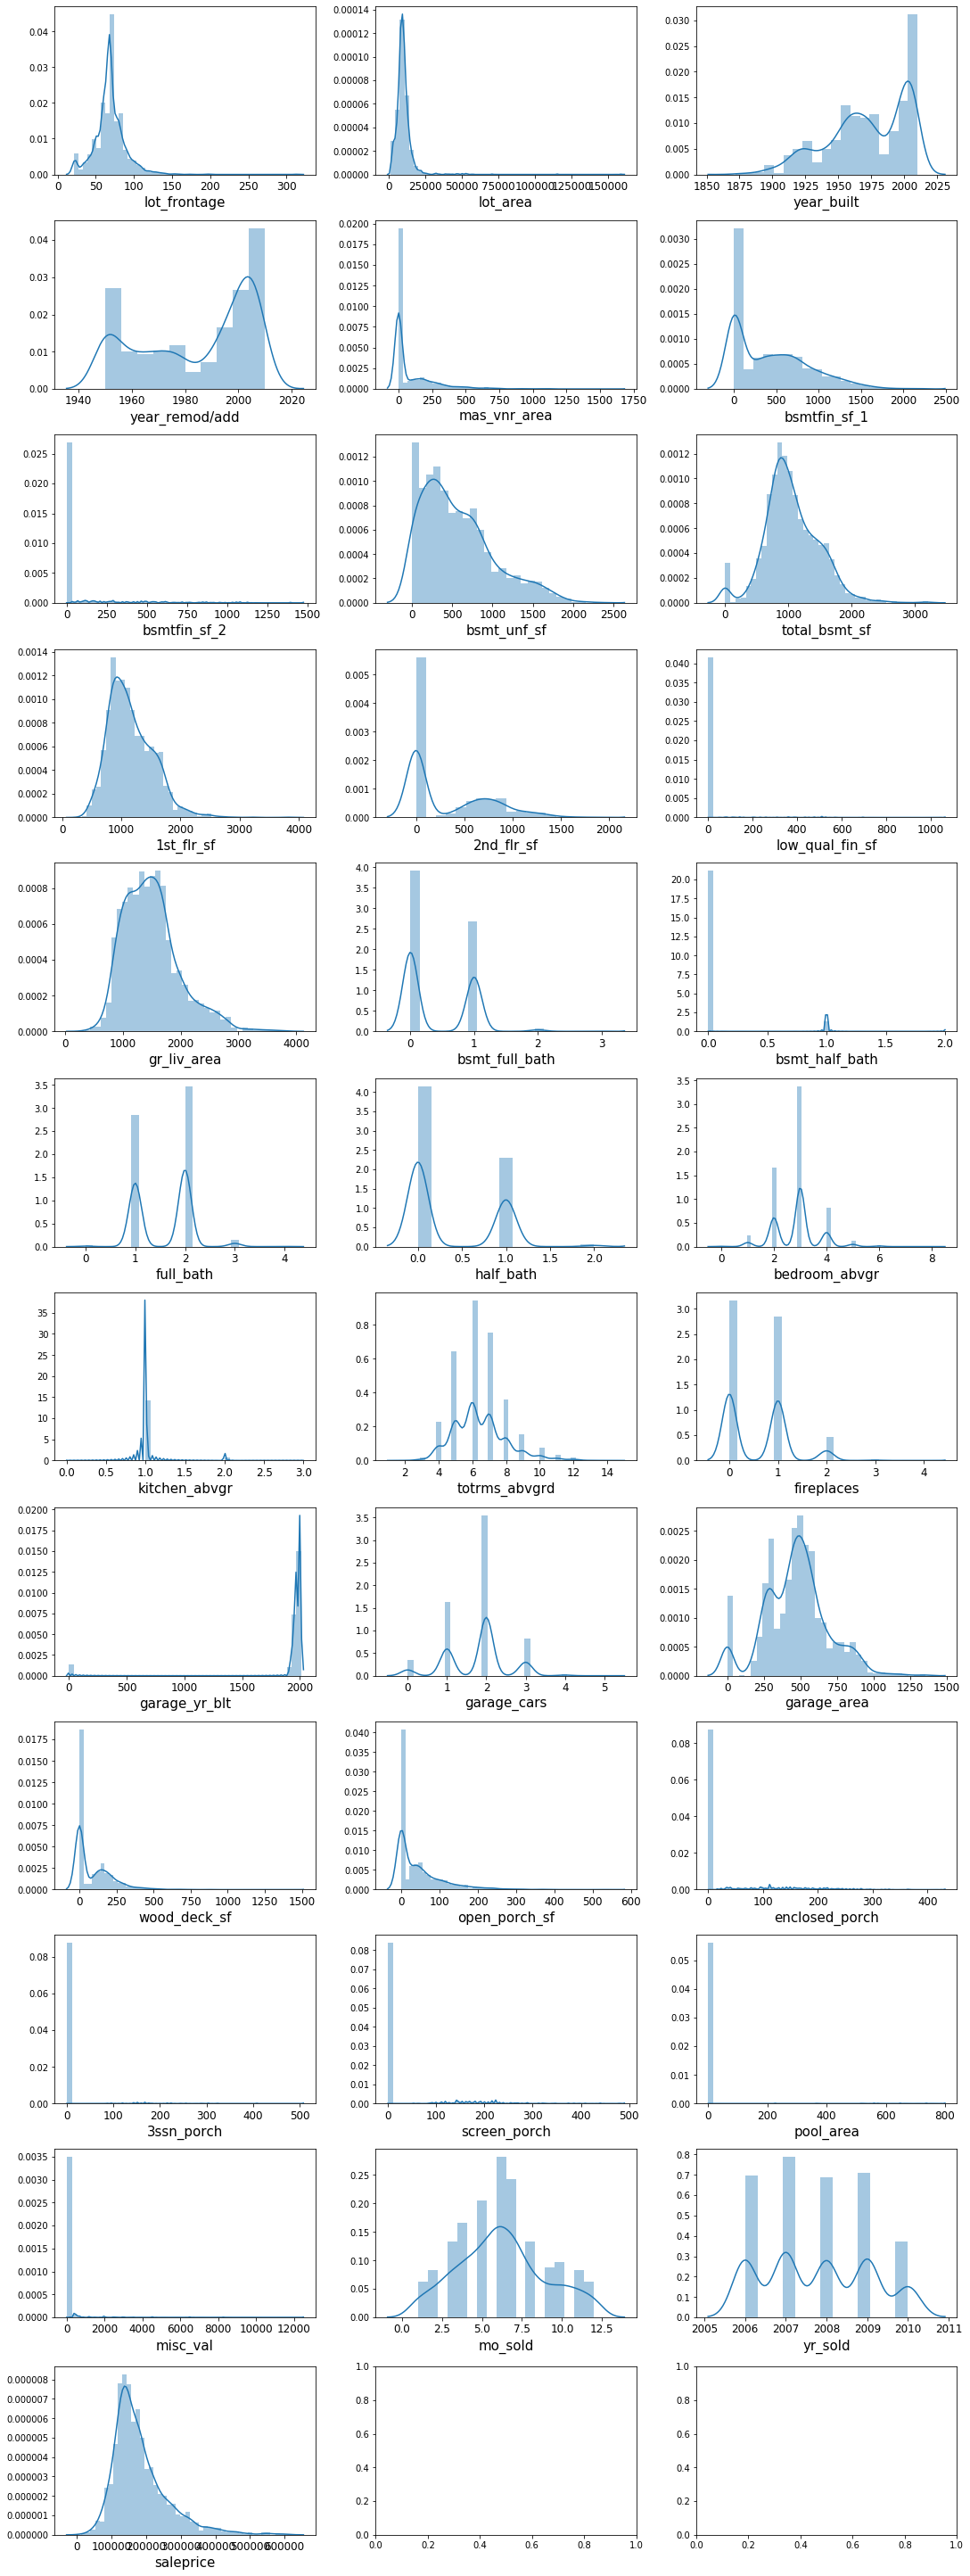

In [648]:
cols = 3
rows = int(np.ceil(len(numeric_columns)/cols))
fig, ax = plt.subplots(nrows = rows,ncols= cols ,figsize=(15,40),constrained_layout=True )
ax = ax.ravel()

for i, col in enumerate(numeric_columns):
    sns.distplot(train_df[col],ax=ax[i])
    ax[i].set_xlabel(col)
    ax[i].set_xlabel(col,fontsize=15)
    ax[i].xaxis.set_tick_params(labelsize=12)


The graphs show that not all of the features are normally distributed. The ones that seem to be normally distribured are:  
lot frontage, lot area, total basement sf, 1st floor sf, gr living area, total rooms abv ground, garage area, and month sold. Sale price is almost relatively normal.

#### Filter outliers in 'lot_area'

In [646]:
train_df[train_df['lot_area']>100000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
471,2116,906426060,50,RL,68.0,159000,Pave,NA,IR2,Low,...,0,0,NA,NA,Shed,500,6,2007,WD,277000
694,2072,905301050,20,RL,68.0,115149,Pave,NA,IR2,Low,...,0,0,NA,NA,NA,0,6,2007,WD,302000


In [652]:
train_df.drop(index=[471,694],inplace=True)

#### plotting the new regplot against the old plot for 'lot_area' vs saleprice

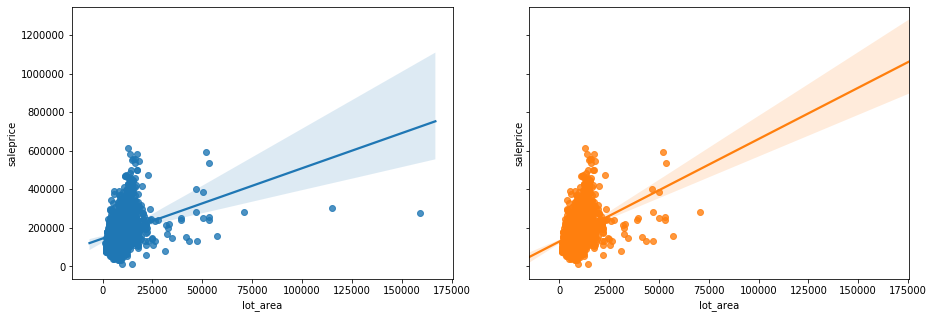

In [677]:

fig , (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(15,5))

sns.regplot(train_df_num_incl_price['lot_area'],train_df_num_incl_price['saleprice'],ax=ax1)
sns.regplot(train_df['lot_area'],train_df['saleprice'],ax=ax2)

Removing the outliers has caused there to be less variance between the points and has caused the best fit line to shift.

# Create dataframe for modelling

In [682]:
trial_df = train_df.iloc[:,2:] # drop Order and Id

The trial_df is the dataframe that will be used for modeling from now on. Since the first two columns of the train_df are just observation identifiers, they will not be included. In addition, non-numeric columns will be recoded so that they can be used for modelling

### Transforming categorical variables into numeric variables

In order for the model to be able to interpret the categorical variables, they first have to be converted to numbers. Ordinal variables will be changed to a range of numbers starting from 0. Nominal variables will be dummy coded, and one column will be dropped.

### Coding for ordinal variables

This code ranks ordinal variables according to the order given in the data dictionary, with the lowest being 0.

In [683]:
for col in trial_df.columns:
    if col == 'lot_shape':
        trial_df[col] = trial_df[col].map({'Reg': 3,'IR1': 2, 'IR2': 1, 'IR3' : 0})
    elif col == 'utilities':
        trial_df[col] = trial_df[col].map({'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0})
    elif col == 'land_slope':
        trial_df[col] = trial_df[col].map({'Gtl':2,'Mod': 1, 'Sev': 0})
    elif col == 'exter_qual' or col == 'exter_cond' or col == 'heating_qc' or col == 'kitchen_qual':
        trial_df[col] = trial_df[col].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    elif col == 'bsmt_qual' or col == 'bsmt_cond' or col == 'fireplace_qu' or col == 'garage_qual' or col == 'garage_cond':
        trial_df[col] = trial_df[col].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
    elif col == 'bsmt_exposure':
        trial_df[col] = trial_df[col].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0})
    elif col == 'bsmtfin_type_1' or col == 'bsmtfin_type_2':
        trial_df[col] = trial_df[col].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0})
    elif col == 'electrical':
        trial_df[col] = trial_df[col].map({'SBrkr':4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 0})
    elif col == 'functional':
        trial_df[col] = trial_df[col].map({'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0})
    elif col == 'garage_finish':
        trial_df[col] = trial_df[col].map({'Fin':3, 'RFn':2, 'Unf':1, 'NA':0})
    elif col == 'paved_drive':
        trial_df[col] = trial_df[col].map({'Y':2,'P':1,'N':0})
    elif col == 'pool_qc':
        trial_df[col] = trial_df[col].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'NA':0})
    elif col == 'fence':
        trial_df[col] = trial_df[col].map({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'NA':0})
    else:
        pass



### coding for nominal variables

In [684]:
trial_df = pd.get_dummies(trial_df,columns=nominal_filter,drop_first=True)

### lowercase,strip and replace spaces for new dummy columns

In [686]:
trial_df.rename(columns=lambda x:x.lower().strip().replace(' ','_'),inplace=True)

### Checking to see if all variables have been turned into numeric values

If all columns have been successfully converted, there should not be any column names shown

In [687]:
trial_df.select_dtypes(include='object').head()

""
0
1
2
3
4


### Observing the new dataframe

In [688]:
trial_df.shape

(2045, 209)

In [689]:
trial_df.head()

,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,...,misc_feature_shed,misc_feature_tenc,sale_type_cwd,sale_type_con,sale_type_conld,sale_type_conli,sale_type_conlw,sale_type_new,sale_type_oth,sale_type_wd
0,68.0,13517,2,3,2,6,8,1976,2005,289.0,...,0,0,0,0,0,0,0,0,0,1
1,43.0,11492,2,3,2,7,5,1996,1997,132.0,...,0,0,0,0,0,0,0,0,0,1
2,68.0,7922,3,3,2,5,7,1953,2007,0.0,...,0,0,0,0,0,0,0,0,0,1
3,73.0,9802,3,3,2,5,5,2006,2007,0.0,...,0,0,0,0,0,0,0,0,0,1
4,82.0,14235,2,3,2,6,8,1900,1993,0.0,...,0,0,0,0,0,0,0,0,0,1


#### heatmap of new dataframe

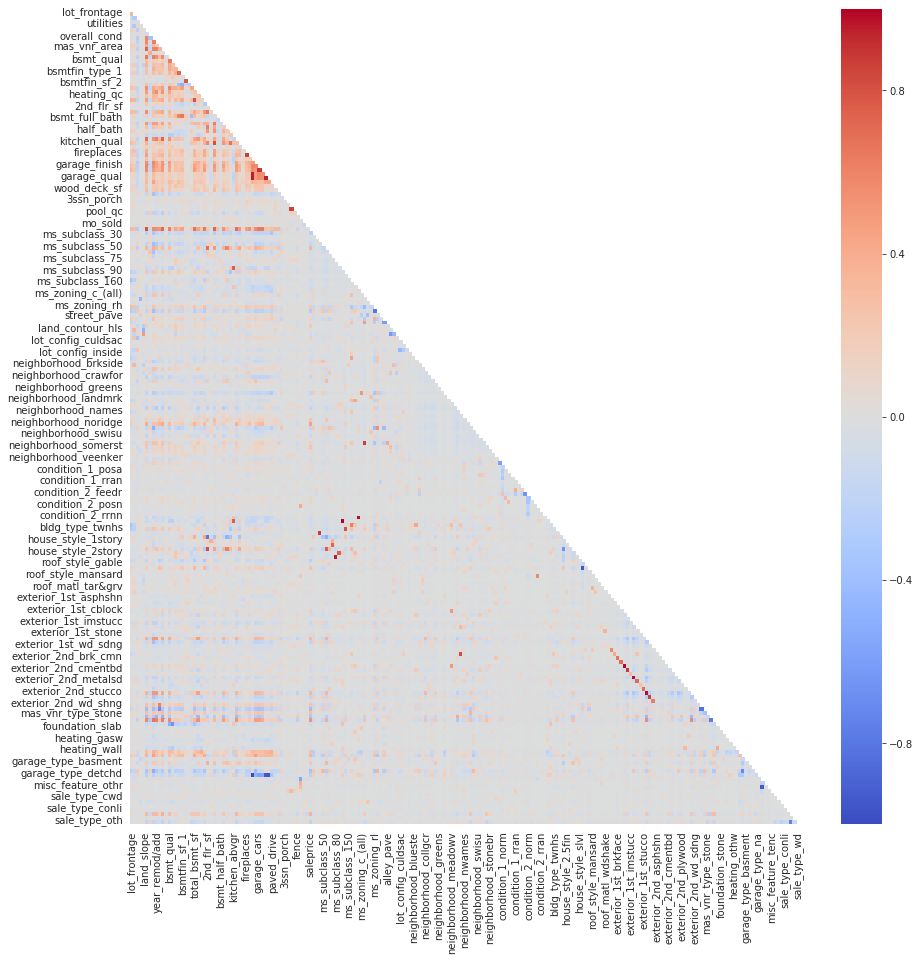

In [306]:
plt.figure(figsize=(15,15))


mask = np.zeros_like(trial_df.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    sns.heatmap(trial_df.corr(), mask=mask, cmap='coolwarm')

#### highest correlated pairs excluding saleprice from dataframe

In [694]:
def get_redundant_pairs(df):
    # Get diagonal and lower triangular pairs of correlation matrix
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop 
# returns a set of tuples to drop so that the second function will not return the same pair of labels

def get_top_abs_correlations(df, n=5):
    # from the pairs of correlations attained from the aove function, return the highest correlated varaibles
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
get_top_abs_correlations(train_df_num, 30)

Top Absolute Correlations


garage_cars     garage_area       0.897014
gr_liv_area     totrms_abvgrd     0.812174
total_bsmt_sf   1st_flr_sf        0.790650
bedroom_abvgr   totrms_abvgrd     0.664840
bsmtfin_sf_1    bsmt_full_bath    0.657375
2nd_flr_sf      gr_liv_area       0.655651
gr_liv_area     full_bath         0.630139
year_built      year_remod/add    0.629487
2nd_flr_sf      half_bath         0.615824
garage_yr_blt   garage_cars       0.587139
2nd_flr_sf      totrms_abvgrd     0.581630
garage_yr_blt   garage_area       0.557847
year_built      garage_cars       0.541975
1st_flr_sf      gr_liv_area       0.530415
gr_liv_area     bedroom_abvgr     0.525912
full_bath       totrms_abvgrd     0.521704
2nd_flr_sf      bedroom_abvgr     0.503252
bsmtfin_sf_1    bsmt_unf_sf       0.500163
gr_liv_area     garage_cars       0.494548
bsmtfin_sf_1    total_bsmt_sf     0.490411
1st_flr_sf      garage_area       0.489319
year_built      garage_area       0.486372
                full_bath         0.480503
gr_liv_area

#### features that are most highly correlated with saleprice

In [698]:
price_vs_num_features_only= pd.DataFrame(trial_df.corr().abs()['saleprice'].sort_values(ascending=False))
price_vs_num_features_only.sort_values('saleprice',ascending=False)[:30].style.background_gradient()
# top 30 features correlated with saleprice

,saleprice
saleprice,1
overall_qual,0.803684
gr_liv_area,0.719249
exter_qual,0.715803
kitchen_qual,0.694291
total_bsmt_sf,0.664281
garage_area,0.655494
garage_cars,0.648687
1st_flr_sf,0.647548
bsmt_qual,0.613373


Since there are so many features, I have decided to use Lasso regression to eliminate features that have a small effect on saleprice and are highly correlated with each other.

# First model - Lasso Regression

### train-test split

Split data into Test and Train set

In [725]:
features = [col for col in trial_df.columns if col != 'saleprice']
X = trial_df[features]
y = trial_df['saleprice']

In [726]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size= 0.7, random_state =42)

### scaling to ensure all features have the same weight

In [727]:
ss = StandardScaler() 
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

### Fit data into Lasso Model

In [728]:
lasso = LassoCV(n_alphas=500)# Search between 500 alphas

In [730]:
lasso.fit(X_train_sc, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=500, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [731]:
lasso.alpha_

599.767722567961

### Assessing Model Accuracy

In [711]:
lasso.score(X_train_sc, y_train)


0.9265795614270821

In [335]:
lasso.score(X_test_sc, y_test)

0.9092641968433948

In [733]:
y_test_pred = lasso.predict(X_test_sc)

In [734]:
rmse = mean_squared_error(y_test, y_test_pred)**0.5
rmse

23562.70124304806

### Plotting Y predict accuracy

In [751]:
def Y_test_vs_Y_predict(Ytest,Ypredict):
    fig = plt.figure(figsize=(15,7))
    plt.scatter(Ytest, Ypredict)
    plt.plot([Ytest.min(), Ytest.max()], [Ytest.min(), Ytest.max()])
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual SalePrice Comparison')

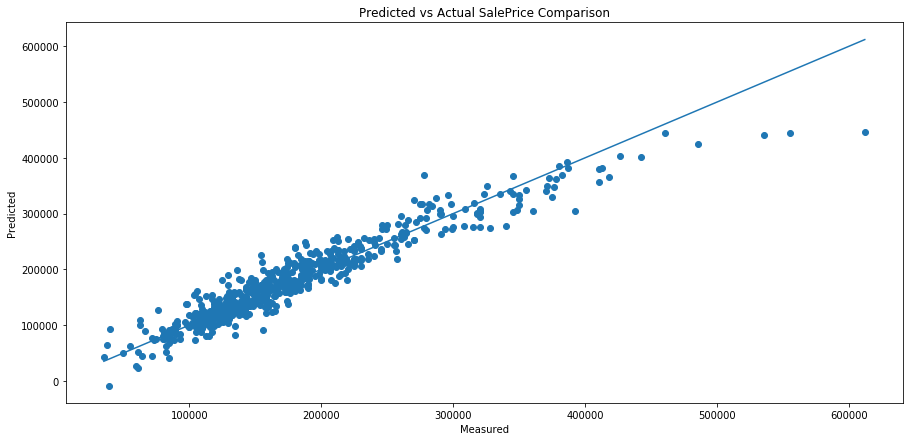

In [752]:
Y_test_vs_Y_predict(y_test,y_test_pred)

### Cross Validate Scores

In [739]:
lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=5)# cross validate the lasso accuracy scores over 5 different folds
print(f'For Training set: Rsquared is {lasso.score(X_train_sc, y_train)}, CVRsquared is {lasso_scores.mean()}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

For Training set: Rsquared is 0.9265795614270821, CVRsquared is 0.9075635879624804


In [740]:
lasso_scores = cross_val_score(lasso, X_test_sc, y_test, cv=5)
print(f'For Test set: Rsquared is {lasso.score(X_test_sc, y_test)}, CVRsquared is {lasso_scores.mean()}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

For Test set: Rsquared is 0.9090893759807571, CVRsquared is 0.892252206806796


## Choosing features for Second model

This model has a decent accuracy in predicting saleprice. However, they are way too many variables. In order to keep the model interpretable, 25 features will be selected for the second model. The 25 best features in the Lasso model will be selected for the new model.

### Plotting Lasso Coefficients

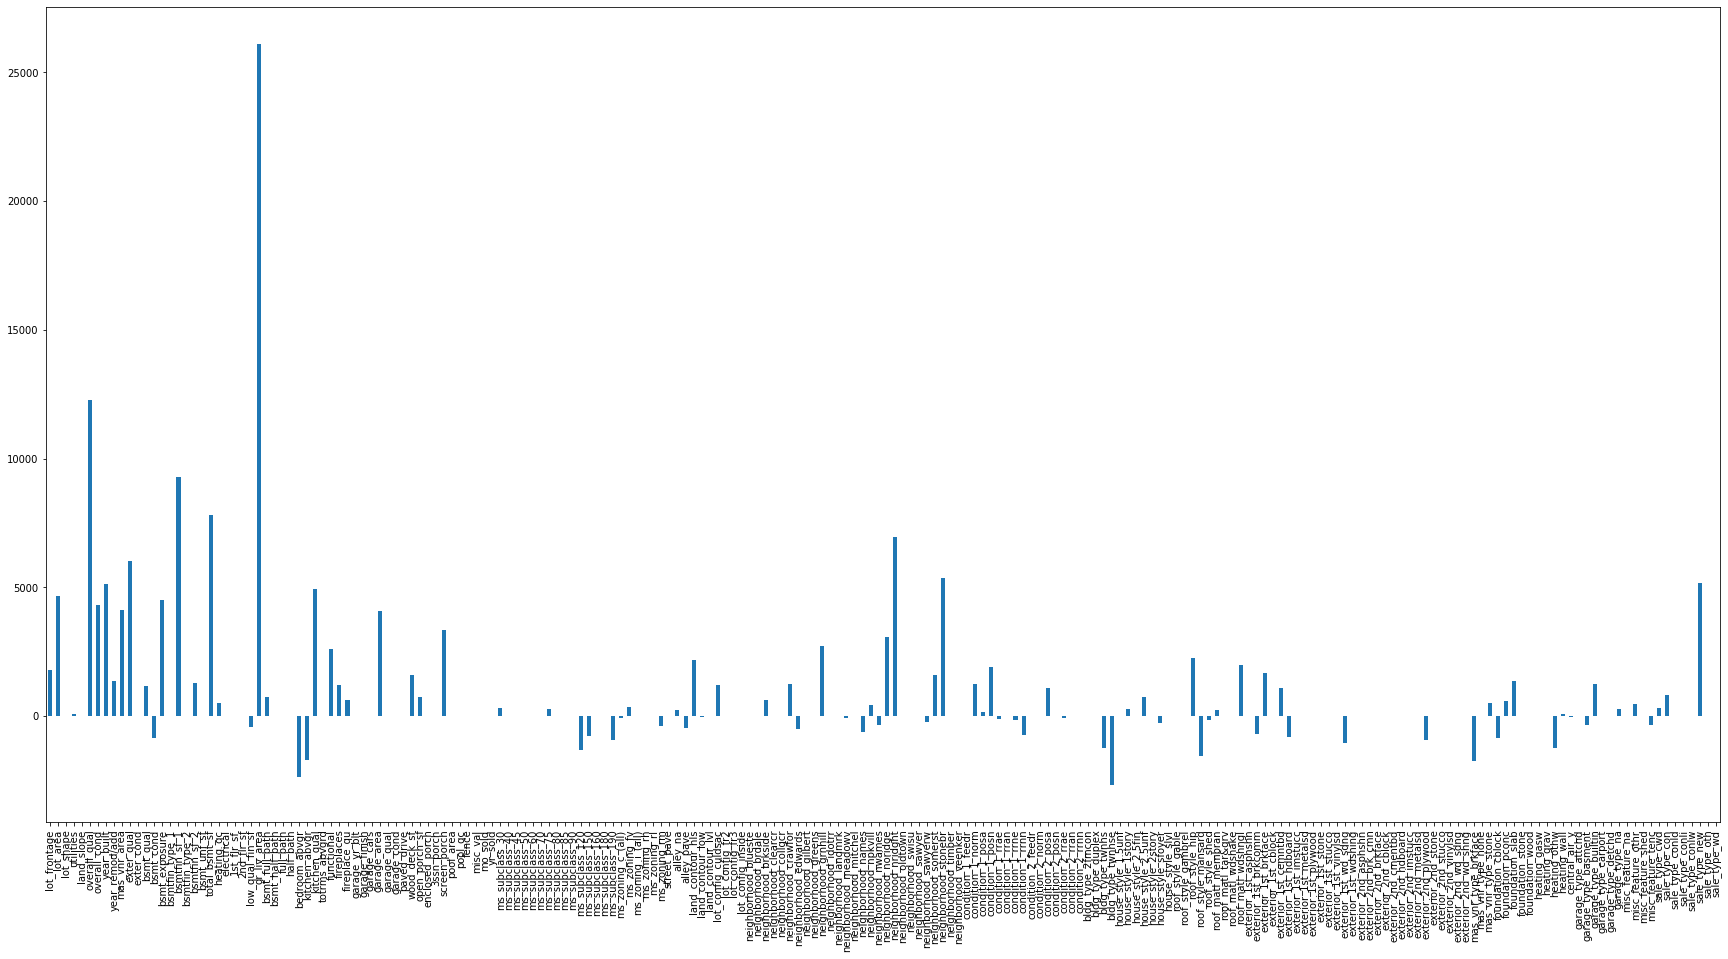

In [741]:
pd.Series(lasso.coef_, index=features).plot.bar(figsize=(30, 15))

In [742]:
len(lasso.coef_)

208

In [743]:
not_zero =  lasso.coef_[lasso.coef_ != 0]
len(not_zero)

96

#### Plotting only for Lasso Coefficients more than 0

In [745]:
not_zero_position = []
for i, coef in enumerate(list(lasso.coef_)):
    
    if abs(coef) >0:
        not_zero_position.append(i)
       


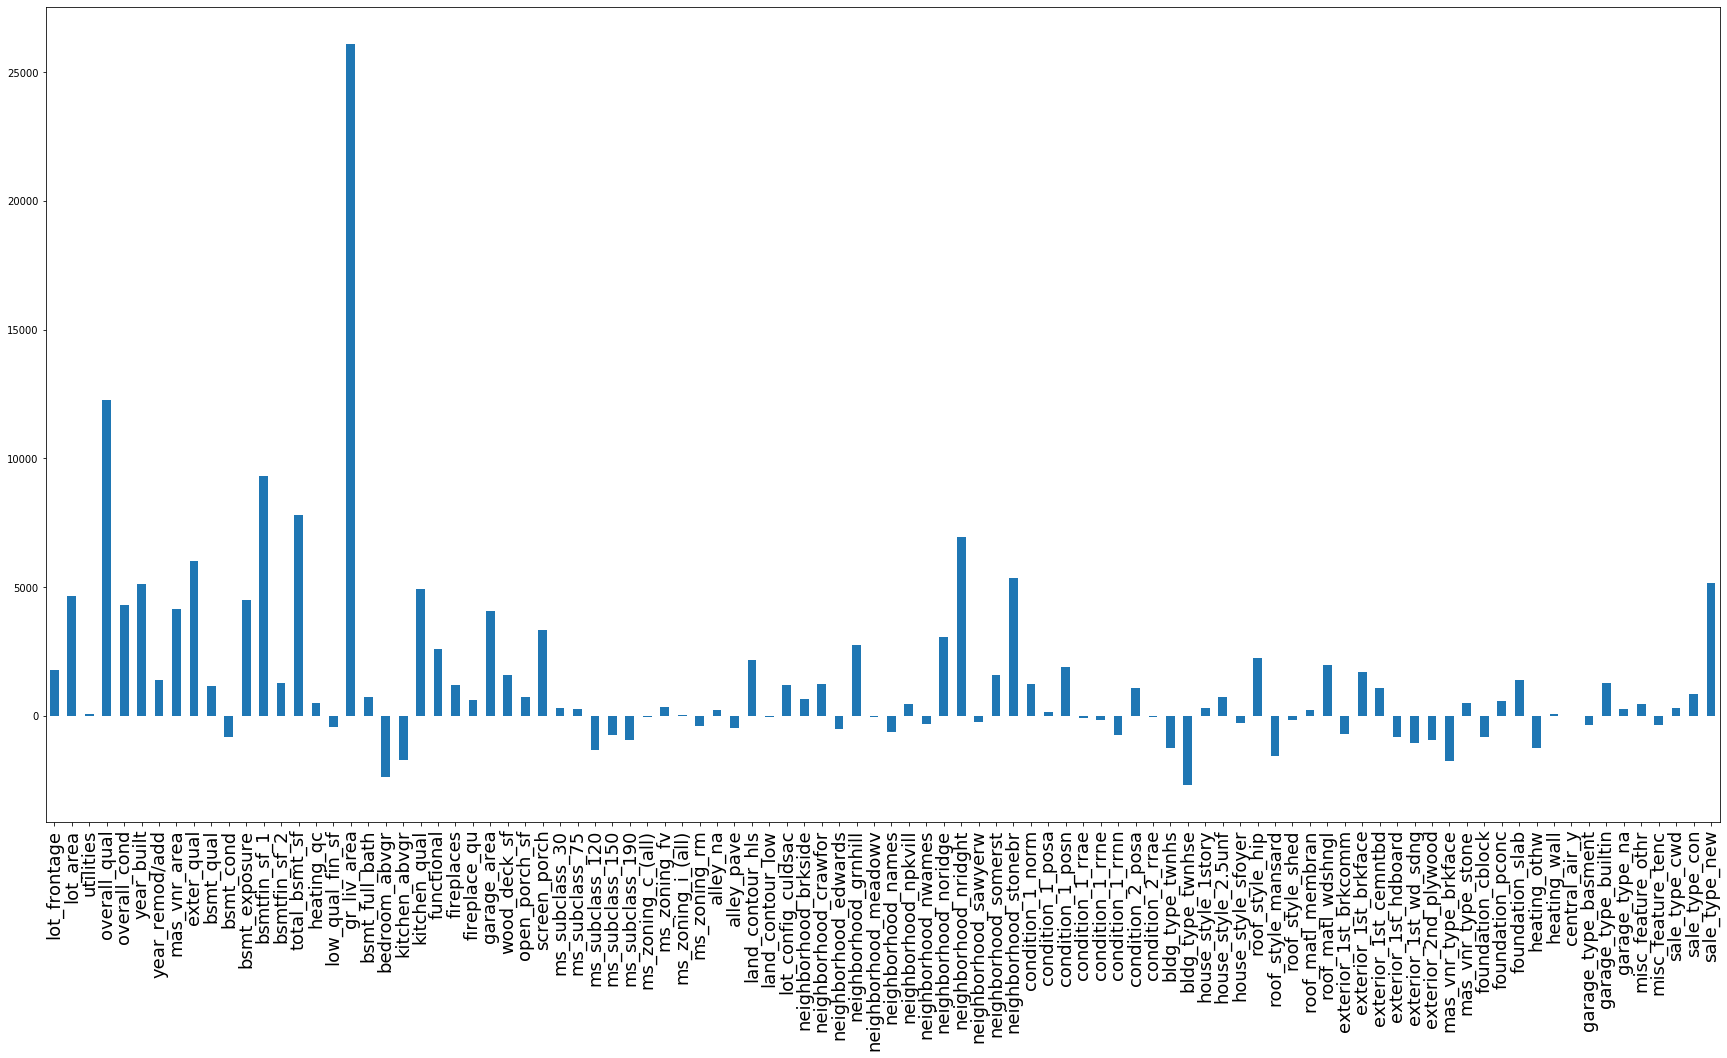

In [746]:
pd.Series(lasso.coef_[lasso.coef_ != 0], index=X.columns[not_zero_position]).plot.bar(figsize=(30, 15))
plt.xticks(fontsize=18);

Here we can see which features result in the largest increase in price. However it is not easy to see from here. So a Dataframe containing this innformation will be made

In [754]:
feature_coefs = pd.DataFrame(enumerate(list(lasso.coef_)),columns=['feature_position','coefficients'])
#Create Dataframe of lasso coeffients

feature_coefs['column_names']= feature_coefs['feature_position'].apply(lambda i : features[i])
#Add column for the feature name for each coefficient

feature_coefs['abs_coef'] = feature_coefs['coefficients'].abs()
#Add column for absolute values of each coefficient

feature_coefs.head()


,feature_position,coefficients,column_names,abs_coef
0,0,1765.208753,lot_frontage,1765.208753
1,1,4647.631563,lot_area,4647.631563
2,2,0.000000,lot_shape,0.000000
3,3,74.414022,utilities,74.414022
4,4,0.000000,land_slope,0.000000


From this dataframe, we are able to pick the 25 features responsible for the largest increase in saleprice. However, since some of them may be correlated, only those with a correlation of less than 0.6 with the other top features will be picked.

In [757]:
top_40_coef = feature_coefs.sort_values(by=['abs_coef'],axis=0,ascending=False).head(40)
#top 40 coefficients sorted by absolute coefficients
top_40_coef.head()

,feature_position,coefficients,column_names,abs_coef
26,26,26105.859583,gr_liv_area,26105.859583
5,5,12259.244726,overall_qual,12259.244726
16,16,9298.132374,bsmtfin_sf_1,9298.132374
20,20,7811.803753,total_bsmt_sf,7811.803753
105,105,6936.403599,neighborhood_nridght,6936.403599


In the next part, the top 40 coefficients will be compared with against each other. If to features are highly correlated with each other, the one with a higher effect on saleprice will be retained.

In [758]:
# Create correlation matrix
corr_matrix = trial_df[top_40_coef['column_names']].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

upper

,gr_liv_area,overall_qual,bsmtfin_sf_1,total_bsmt_sf,neighborhood_nridght,exter_qual,neighborhood_stonebr,sale_type_new,year_built,kitchen_qual,...,wood_deck_sf,roof_style_mansard,foundation_slab,year_remod/add,ms_subclass_120,bsmtfin_sf_2,garage_type_builtin,heating_othw,bldg_type_twnhs,condition_1_norm
gr_liv_area,NaN,0.56517,0.153299,0.409135,0.233181,0.429003,0.137846,0.153389,0.258425,0.440937,...,0.262543,0.043954,0.028161,0.322082,0.069642,0.003766,0.280329,0.045923,0.102226,0.009168
overall_qual,NaN,NaN,0.266701,0.552370,0.384300,0.738878,0.226267,0.329378,0.602126,0.689307,...,0.252485,0.001374,0.174105,0.584113,0.223315,0.027567,0.192521,0.019597,0.006778,0.113611
bsmtfin_sf_1,NaN,NaN,NaN,0.489695,0.175033,0.228917,0.088161,0.010351,0.278222,0.244722,...,0.204782,0.024378,0.129371,0.162864,0.125621,0.049559,0.071296,0.010564,0.037699,0.034281
total_bsmt_sf,NaN,NaN,NaN,NaN,0.343036,0.471148,0.155338,0.230821,0.420946,0.439908,...,0.215396,0.035561,0.321317,0.313158,0.169401,0.094654,0.049392,0.025230,0.139562,0.061766
neighborhood_nridght,NaN,NaN,NaN,NaN,NaN,0.403621,0.034658,0.244141,0.281178,0.373257,...,0.121035,0.014762,0.032751,0.259747,0.169090,0.054411,0.135483,0.007881,0.032972,0.088761
exter_qual,NaN,NaN,NaN,NaN,NaN,NaN,0.195282,0.384356,0.616194,0.729746,...,0.204106,0.002368,0.102856,0.617304,0.249696,0.041278,0.185196,0.021610,0.018190,0.121400
neighborhood_stonebr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.109362,0.123724,0.182109,...,0.054739,0.008064,0.017892,0.098016,0.229105,0.010786,0.111216,0.004305,0.025713,0.023526
sale_type_new,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.334305,0.335087,...,0.010027,0.016959,0.037625,0.314859,0.065598,0.084238,0.087957,0.009054,0.054072,0.025431
year_built,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537467,...,0.215150,0.033586,0.056967,0.630036,0.229124,0.021018,0.212896,0.080086,0.074470,0.176586
kitchen_qual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.220938,0.020260,0.100865,0.616574,0.203569,0.014062,0.173618,0.024271,0.038979,0.116000


In [760]:
# Find index of feature columns with correlation greater than 0.60
to_drop = [column for column in upper.columns if any(upper[column] > 0.60)]

# Drop features 
uncorrelated = trial_df[top_40_coef['column_names']].drop(trial_df[top_40_coef['column_names']][to_drop], axis=1)

In [761]:
uncorrelated.columns


Index(['gr_liv_area', 'overall_qual', 'bsmtfin_sf_1', 'total_bsmt_sf',
       'neighborhood_nridght', 'neighborhood_stonebr', 'sale_type_new',
       'lot_area', 'bsmt_exposure', 'overall_cond', 'mas_vnr_area',
       'garage_area', 'screen_porch', 'neighborhood_noridge',
       'neighborhood_grnhill', 'bldg_type_twnhse', 'functional',
       'bedroom_abvgr', 'roof_style_hip', 'land_contour_hls',
       'roof_matl_wdshngl', 'condition_1_posn', 'lot_frontage',
       'kitchen_abvgr', 'exterior_1st_brkface', 'neighborhood_somerst',
       'wood_deck_sf', 'roof_style_mansard', 'foundation_slab', 'bsmtfin_sf_2',
       'garage_type_builtin', 'heating_othw', 'bldg_type_twnhs',
       'condition_1_norm'],
      dtype='object')

#### Show top 25 non correlated columns

In [762]:
def highlight(val):

    return 'background-color: yellow' if val in uncorrelated.columns else ''

In [763]:
top_40_coef.style.applymap(highlight)

,feature_position,coefficients,column_names,abs_coef
26,26,26105.9,gr_liv_area,26105.9
5,5,12259.2,overall_qual,12259.2
16,16,9298.13,bsmtfin_sf_1,9298.13
20,20,7811.8,total_bsmt_sf,7811.8
105,105,6936.4,neighborhood_nridght,6936.4
10,10,6004.65,exter_qual,6004.65
111,111,5365.83,neighborhood_stonebr,5365.83
205,205,5166.76,sale_type_new,5166.76
7,7,5119.52,year_built,5119.52
33,33,4916.32,kitchen_qual,4916.32


#### show correlation between top 25 columns and Saleprice

In [768]:
correlation_btwn_top_25_and_price= trial_df.corr().loc[uncorrelated.columns[:25],['saleprice',]]

correlation_btwn_top_25_and_price.abs().sort_values('saleprice',ascending=False).style.background_gradient()

,saleprice
overall_qual,0.803684
gr_liv_area,0.719249
total_bsmt_sf,0.664281
garage_area,0.655494
mas_vnr_area,0.510069
neighborhood_nridght,0.449409
bsmtfin_sf_1,0.444958
bsmt_exposure,0.423995
sale_type_new,0.361269
lot_area,0.351666


Now that the top 25 have been chosen, its time to make the second model using ridge regression

# Second Model - Ridge Regression

### Select 25 top predictors

In [776]:
top_25_coef = uncorrelated.columns[:25]
top_25_coef

Index(['gr_liv_area', 'overall_qual', 'bsmtfin_sf_1', 'total_bsmt_sf',
       'neighborhood_nridght', 'neighborhood_stonebr', 'sale_type_new',
       'lot_area', 'bsmt_exposure', 'overall_cond', 'mas_vnr_area',
       'garage_area', 'screen_porch', 'neighborhood_noridge',
       'neighborhood_grnhill', 'bldg_type_twnhse', 'functional',
       'bedroom_abvgr', 'roof_style_hip', 'land_contour_hls',
       'roof_matl_wdshngl', 'condition_1_posn', 'lot_frontage',
       'kitchen_abvgr', 'exterior_1st_brkface'],
      dtype='object')

The previous X_train and X_test will be filtered down to the 25 columns selected

In [778]:
X_train_top_25 = X_train[top_25_coef]
X_test_top_25 = X_test[top_25_coef]

### Scale data

In [782]:
ss_ridge = StandardScaler() 
ss_ridge.fit(X_train_top_25)
X_train_top_25_sc = ss_ridge.transform(X_train_top_25)
X_test_top_25_sc = ss_ridge.transform(X_test_top_25)

### Fit data into Ridge model

In [783]:
ridge = RidgeCV(alphas=np.linspace(.1, 15, 500))

In [785]:
ridge.fit(X_train_top_25_sc, y_train)

RidgeCV(alphas=array([ 0.1       ,  0.12985972,  0.15971944,  0.18957916,  0.21943888,
        0.2492986 ,  0.27915832,  0.30901804,  0.33887776,  0.36873747,
        0.39859719,  0.42845691,  0.45831663,  0.48817635,  0.51803607,
        0.54789579,  0.57775551,  0.60761523,  0.63747495,  0.66733467,
        0.69719439,  0.72705411,  0.75691383,  0.78677355,  0.81663327,
        0.84649299,  0.87635271,  0.90621242,  0.93607214,  0.96593186,
        0.9957...
       14.28336673, 14.31322645, 14.34308617, 14.37294589, 14.40280561,
       14.43266533, 14.46252505, 14.49238477, 14.52224449, 14.55210421,
       14.58196393, 14.61182365, 14.64168337, 14.67154309, 14.70140281,
       14.73126253, 14.76112224, 14.79098196, 14.82084168, 14.8507014 ,
       14.88056112, 14.91042084, 14.94028056, 14.97014028, 15.        ]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [786]:
ridge.alpha_

11.864729458917836

### Model accuracy

In [787]:
ridge.score(X_train_top_25_sc,y_train)

0.8971756115861294

In [788]:
ridge.score(X_test_top_25_sc,y_test)

0.8779800287287625

In [800]:
y_test2_pred = ridge.predict(X_test_top_25_sc)

In [801]:
rmse = mean_squared_error(y_test,y_test2_pred)**0.5
rmse

27298.150045792703

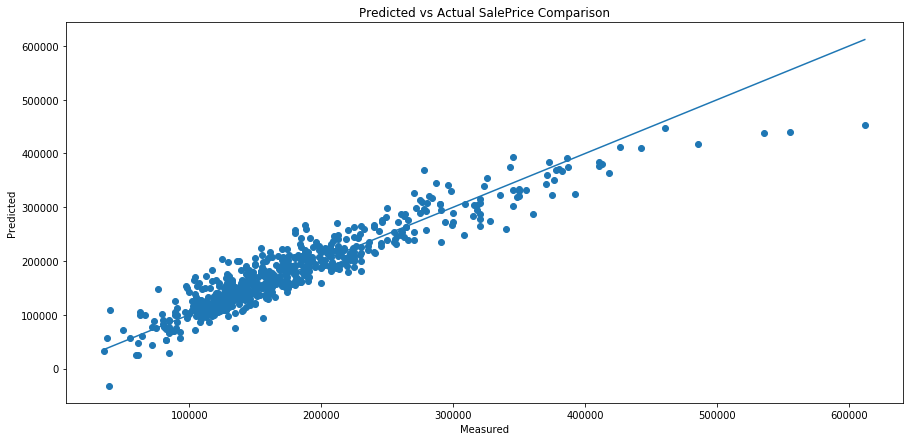

In [806]:
Y_test_vs_Y_predict(y_test,y_test2_pred)

### Cross Val score

In [807]:
ridge_scores = cross_val_score(ridge, X_train_top_25_sc, y_train, cv=5)
ridge_scores.mean()

0.8878071343990361

Text(0.5, 1.0, 'Ridge Model Coefficients')

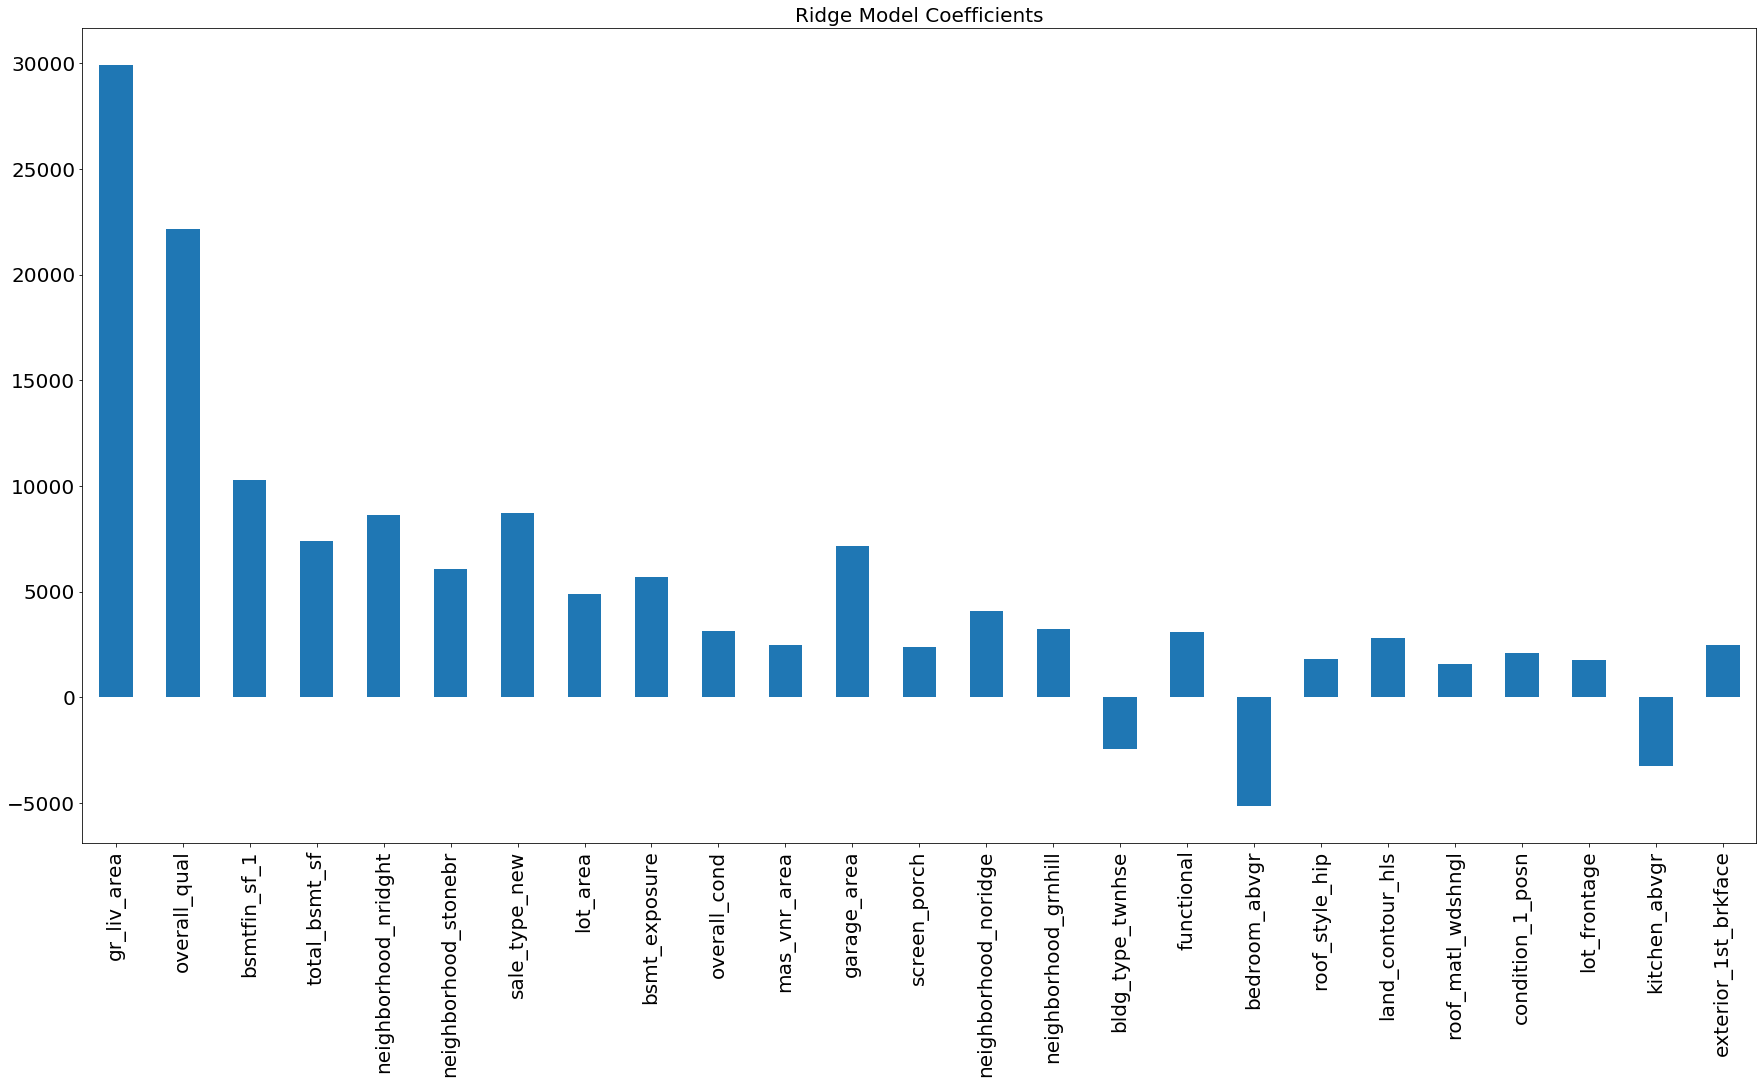

In [793]:
pd.Series(ridge.coef_, index=top_25_coef).plot.bar(figsize=(30, 15))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Ridge Model Coefficients',fontsize=20)

# Test Dataset

## Test data cleaning

## Apply the same cleaning method to the Test data set as the train dataset

In [842]:
test_df = pd.read_csv('datasets/test.csv', keep_default_na=False, na_values=[''])
test_df.loc[:, test_df.isna().any()].isna().sum()

Lot Frontage     160
Mas Vnr Type       1
Mas Vnr Area       1
Electrical         1
Garage Yr Blt     45
Garage Finish      1
dtype: int64

In [843]:
test_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NA,Reg,Lvl,...,0,0,0,NA,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NA,IR1,Lvl,...,0,185,0,NA,NA,NA,0,7,2009,WD


In [844]:
test_df.rename(columns=lambda x:x.lower().strip().replace(' ','_'),inplace=True) #rename columns

In [845]:
test_df['mas_vnr_type'].fillna('None',inplace=True) #fill empty cells

In [846]:
test_df['lot_frontage'].fillna(test_df['lot_frontage'].median(),inplace=True)

In [847]:
test_df['electrical'].fillna('Mix',inplace=True)

In [848]:
test_df=test_df.apply(lambda x: x.fillna('NA') if x.dtypes == 'O' else x.fillna(0))#fill empty cells
test_df.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,68.0,9662,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NA,Reg,Lvl,...,0,0,0,NA,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,68.0,9500,Pave,NA,IR1,Lvl,...,0,185,0,NA,NA,NA,0,7,2009,WD


In [849]:
test_df.loc[:, test_df.isna().any()].isna().sum() # check remaining missing

Series([], dtype: float64)

In [850]:
top_25_coef

Index(['gr_liv_area', 'overall_qual', 'bsmtfin_sf_1', 'total_bsmt_sf',
       'neighborhood_nridght', 'neighborhood_stonebr', 'sale_type_new',
       'lot_area', 'bsmt_exposure', 'overall_cond', 'mas_vnr_area',
       'garage_area', 'screen_porch', 'neighborhood_noridge',
       'neighborhood_grnhill', 'bldg_type_twnhse', 'functional',
       'bedroom_abvgr', 'roof_style_hip', 'land_contour_hls',
       'roof_matl_wdshngl', 'condition_1_posn', 'lot_frontage',
       'kitchen_abvgr', 'exterior_1st_brkface'],
      dtype='object')

In [851]:
final_df = test_df.iloc[:,2:]

In [852]:
for col in final_df.columns:
    if col == 'lot_shape':
        final_df[col] = final_df[col].map({'Reg': 3,'IR1': 2, 'IR2': 1, 'IR3' : 0})
    elif col == 'utilities':
        final_df[col] = final_df[col].map({'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0})
    elif col == 'land_slope':
        final_df[col] = final_df[col].map({'Gtl':2,'Mod': 1, 'Sev': 0})
    elif col == 'exter_qual' or col == 'exter_cond' or col == 'heating_qc' or col == 'kitchen_qual':
        final_df[col] = final_df[col].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    elif col == 'bsmt_qual' or col == 'bsmt_cond' or col == 'fireplace_qu' or col == 'garage_qual' or col == 'garage_cond':
        final_df[col] = final_df[col].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
    elif col == 'bsmt_exposure':
        final_df[col] = final_df[col].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0})
    elif col == 'bsmtfin_type_1' or col == 'bsmtfin_type_2':
        final_df[col] = final_df[col].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0})
    elif col == 'electrical':
        final_df[col] = final_df[col].map({'SBrkr':4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 0})
    elif col == 'functional':
        final_df[col] = final_df[col].map({'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0})
    elif col == 'garage_finish':
        final_df[col] = final_df[col].map({'Fin':3, 'RFn':2, 'Unf':1, 'NA':0})
    elif col == 'paved_drive':
        final_df[col] = final_df[col].map({'Y':2,'P':1,'N':0})
    elif col == 'pool_qc':
        final_df[col] = final_df[col].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'NA':0})
    elif col == 'fence':
        final_df[col] = final_df[col].map({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'NA':0})
    else:
        pass

In [853]:
final_df = pd.get_dummies(final_df,columns=nominal_filter,drop_first=False)

In [855]:
final_df.rename(columns=lambda x:x.lower().strip().replace(' ','_'),inplace=True)

In order for the model to work, the test dataset needs to have the same variables as the train_dataset. The relevant dummy columns will be added and coded as 0

In [858]:
not_in_test = []
for item in features:
    if item not in final_df.columns:
        not_in_test.append(item)
not_in_test

['ms_subclass_150',
 'neighborhood_grnhill',
 'neighborhood_landmrk',
 'condition_2_rrae',
 'condition_2_rran',
 'condition_2_rrnn',
 'roof_matl_membran',
 'exterior_1st_cblock',
 'exterior_1st_imstucc',
 'exterior_1st_stone',
 'exterior_2nd_stone',
 'heating_othw',
 'heating_wall',
 'misc_feature_tenc']

In [859]:
for col in not_in_test:
    final_df[col]=0

## Test data prediction

In [861]:
X2 = final_df[top_25_coef]

In [862]:
testset_X = X2[X_train_top_25.columns]

In [863]:
testset_X_scaled  = ss_ridge.transform(testset_X)

In [864]:
testset_pred = ridge.predict(testset_X_scaled)

In [865]:
prediction = test_df[['id']]

In [866]:
prediction['SalePrice'] = testset_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [867]:
prediction.set_index('id',inplace=True)

In [868]:
prediction.to_csv('submission.csv')

In [869]:
# !kaggle competitions submit -c dsi-us-6-project-2-regression-challenge -f submission.csv -m "Latest"

Successfully submitted to DSI-US-6 Project 2 Regression Challenge



  0%|          | 0.00/20.8k [00:00<?, ?B/s]
100%|##########| 20.8k/20.8k [00:09<00:00, 2.16kB/s]


RSME according to Kaggle: 29251.51383

# Conclusion

This model gives an idea of what variables are the best at predicting house price. From the looks of the regression model, It seems that living area, basements, garages, lot area, overall quality, how new the house is and the neighbourhood that you live in are some of the more important aspects of house price.